# Progetto Business Intelligence per i Servizi Finanziari (a.a. 2023-2024)
Luca Pinciroli 885969

## 1. Dati utilizzati

Per prima cosa importiamo le librerie che serviranno a compiere tutte le operazioni necessarie.

In [1]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import seaborn as sns
from scipy import stats
import getFamaFrenchFactors as gff
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display_html
import scipy.optimize as sco
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default')

Dopodiché creiamo una semplice funzione che consente di scaricare i dati giornalieri di un'azione da Yahoo Finance e salvarli in formato CSV per averli sempre a disposizione.

In [2]:
def prendi_dati_titolo(ticker, start_date, end_date):
    
    data_dir = "DatiFinanziari" # Nome della cartella per i file CSV
    os.makedirs(data_dir, exist_ok=True)
    
    
    csv_file = os.path.join(data_dir, f"{ticker}.csv") # Nome del file CSV basato sul ticker
    
    # Funzione per caricare i dati dal CSV
    def carica_da_csv():
        try:
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            if(df.index[0] > start_date):
                return None
            else:
                df = df.loc[start_date:end_date]
                return df
        except (FileNotFoundError, pd.errors.EmptyDataError):
            return None
    
    # Funzione per scaricare i dati da Yahoo Finance e salvarli in un CSV
    def scarica_da_yahoo():
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_csv(csv_file)
        return df
    
    data = carica_da_csv()
    
    if data is None or data.empty:
        data = scarica_da_yahoo()
    
    return data

Scarichiamo i dati dei titoli scelti ed inseriamoli in un DataFrame indicizzato per titolo e data.

In [3]:
# periodo di interesse per tutte le analisi
inizio = dt.datetime(2014, 5, 31)
fine = dt.datetime(2024, 5, 31)

settore_1 = 'Tecnologia elettronica'
settore_2 = 'Vendita al dettaglio'
settore_3 = 'Servizi commerciali'

tickers_settore1 = ['AAPL', 'INTC'] # Tecnologia elettronica
tickers_settore2 = ['AMZN', 'WMT'] # Vendita al dettaglio
tickers_settore3 = ['V', 'MA'] # Servizi commerciali

# Apple, Intel, Amazon, Walmart, Visa, Mastercard
tickers = tickers_settore1 + tickers_settore2 + tickers_settore3
data_frames = []

# reperimento dei dati per ciascun titolo
for ticker in tickers:
    df = prendi_dati_titolo(ticker, inizio, fine)
    df['Ticker'] = ticker
    data_frames.append(df)
    
dataframe_completo = pd.concat(data_frames)
dataframe_completo.set_index(['Ticker', dataframe_completo.index], inplace=True)

dataframe_completo

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2014-06-02   22.641430   22.672501   22.232143   22.451786   19.886333   
       2014-06-03   22.445000   22.812143   22.437500   22.769285   20.167551   
       2014-06-04   22.765715   23.138929   22.718214   23.029285   20.397844   
       2014-06-05   23.078571   23.191786   22.950357   23.119642   20.477877   
       2014-06-06   23.210714   23.259287   23.016787   23.056070   20.421566   
...                       ...         ...         ...         ...         ...   
MA     2024-05-23  456.519989  458.049988  450.440002  451.209991  451.209991   
       2024-05-24  452.510010  454.450012  450.320007  451.179993  451.179993   
       2024-05-28  450.000000  450.630005  442.399994  445.079987  445.079987   
       2024-05-29  442.109985  444.559998  441.799988  442.470001  442.470001   
       2024-05-30  442.209991  444.190002  440.670013  442.100006  442.100006   

                      Volume  
Ticker Date                   
AAPL   2014-06-02  369350800  
       2014-06-03  292709200  
       2014-06-04  335482000  
       2014-06-05  303805600  
       2014-06-06  349938400  
...                      ...  
MA     2024-05-23    2084600  
       2024-05-24    2162100  
       2024-05-28    2670800  
       2024-05-29    1876900  
       2024-05-30    2189900  

[15102 rows x 6 columns]

In un apposito DataFrame estraiamo i prezzi di chiusura (aggiustata) di ciascun titolo e visualizziamone l'andamento su un grafico.

In [4]:
prezzi_chiusura_giornalieri = dataframe_completo.reset_index().pivot_table(index='Date', columns='Ticker', values='Adj Close', sort=False)
prezzi_chiusura_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-02,19.886333,20.856436,15.442000,20.799515,49.775627,72.443573
2014-06-03,20.167551,21.162476,15.359500,20.785963,49.262787,71.785400
2014-06-04,20.397844,21.116568,15.339000,20.899773,49.288422,71.757217
2014-06-05,20.477877,21.162476,16.178499,20.951252,49.472580,72.246117
2014-06-06,20.421566,21.552679,16.483500,20.921446,49.654408,72.838432
...,...,...,...,...,...,...
2024-05-23,186.880005,30.080000,181.050003,64.839996,274.230011,451.209991
2024-05-24,189.979996,30.719999,180.750000,65.379997,274.489990,451.179993
2024-05-28,189.990005,31.059999,182.149994,65.040001,270.980011,445.079987


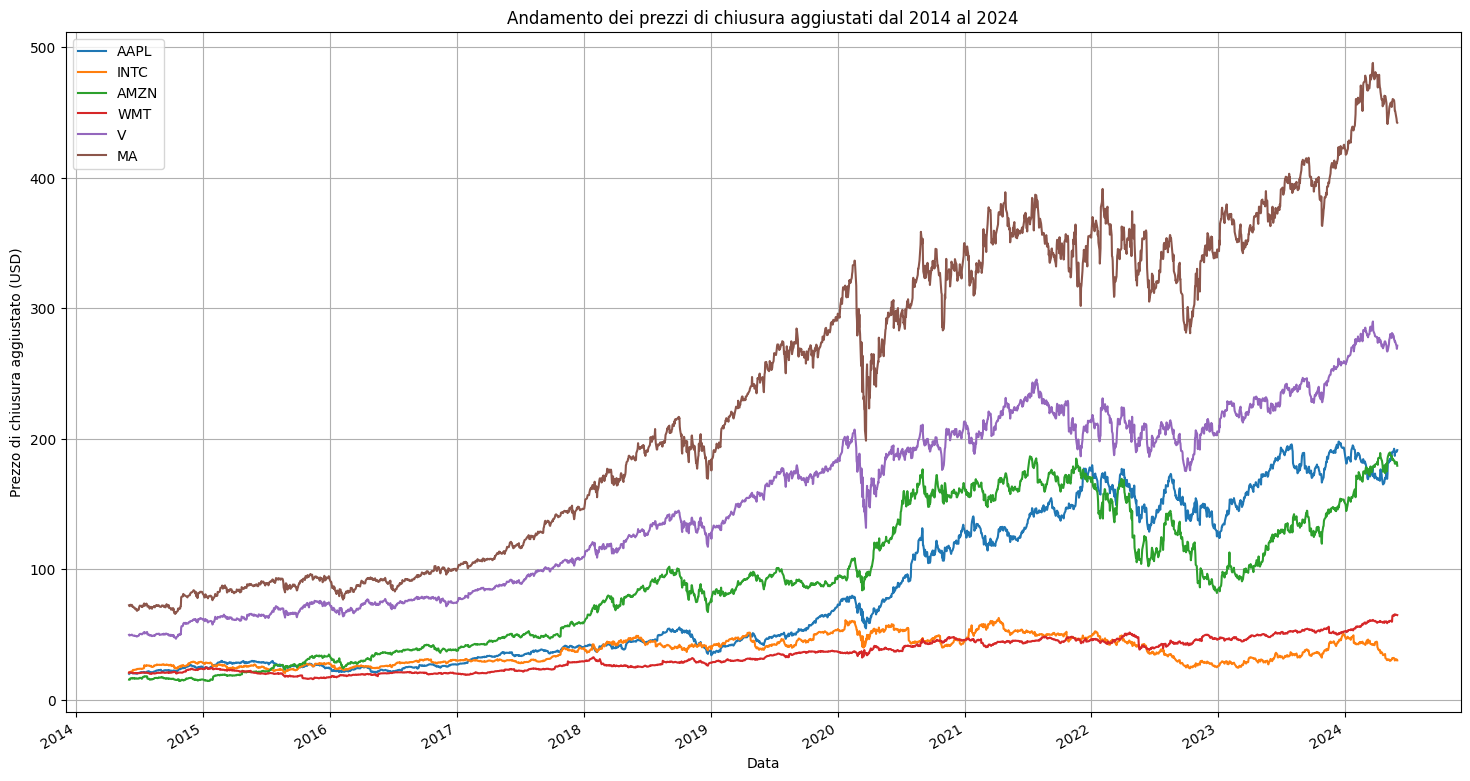

In [5]:
prezzi_chiusura_giornalieri.plot(figsize=(18, 10))
plt.title('Andamento dei prezzi di chiusura aggiustati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura aggiustato (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Statistiche descrittive

Procediamo con il calcolo del rendimento cumulato per ciascun titolo.

In primis definiamo una funzione che ci consenta di rappresentare i grafici di ciascun titolo in maniera separata, per evitare di fare confusione.

In [6]:
# Per creare i grafici utilizzo la mappa dei colori predefinita di matplotlib: in questo modo, ogni ticker mantiene il proprio colore nei diversi grafici
mappa_colori = plt.get_cmap('tab10') 

def crea_grafici_separati(dataframe, label):
    # Numero totale di grafici
    n = len(tickers)
    
    # Calcola il numero di righe necessarie
    rows = (n + 1) // 2
    
    # Crea una griglia di sottotrame
    fig, axes = plt.subplots(rows, 2, figsize=(18, 6 * rows))
    
    # Se c'è un numero dispari di grafici, disabilita l'ultima trama vuota
    if n % 2 != 0:
        axes[-1, -1].axis('off')
    
    # Itera attraverso i tickers e genera un grafico separato per ciascuno di essi
    for i, ticker in enumerate(tickers):
        ax = axes[i // 2, i % 2]
        
        # Seleziona solo i dati relativi al ticker corrente
        data = dataframe[ticker]

        # Crea il grafico
        ax.plot(data.index, data, label=ticker, color=mappa_colori(i))  
        ax.set_title(f'{ticker}')  
        ax.set_xlabel('Data')  
        ax.set_ylabel(label) 
        ax.legend() 
        ax.grid(True)

    plt.tight_layout()
    plt.show()

A partire dal DataFrame contenente i prezzi di chiusura giornalieri andiamo a ricavare i rendimenti netti e lordi.

In [7]:
# calcolo i rendimenti netti (come variazione di prezzo giornaliera) e rimuovo i NaN
rendimenti_netti_giornalieri = prezzi_chiusura_giornalieri.pct_change().dropna()
rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014141,0.014674,-0.005343,-0.000652,-0.010303,-0.009085
2014-06-04,0.011419,-0.002169,-0.001335,0.005475,0.000520,-0.000393
2014-06-05,0.003924,0.002174,0.054730,0.002463,0.003736,0.006813
2014-06-06,-0.002750,0.018438,0.018852,-0.001423,0.003675,0.008199
2014-06-09,0.016002,-0.009230,-0.006582,-0.002590,-0.001972,-0.007874
...,...,...,...,...,...,...
2024-05-23,-0.021058,-0.042648,-0.011358,-0.006284,-0.004899,-0.011631
2024-05-24,0.016588,0.021277,-0.001657,0.008328,0.000948,-0.000066
2024-05-28,0.000053,0.011068,0.007745,-0.005200,-0.012787,-0.013520


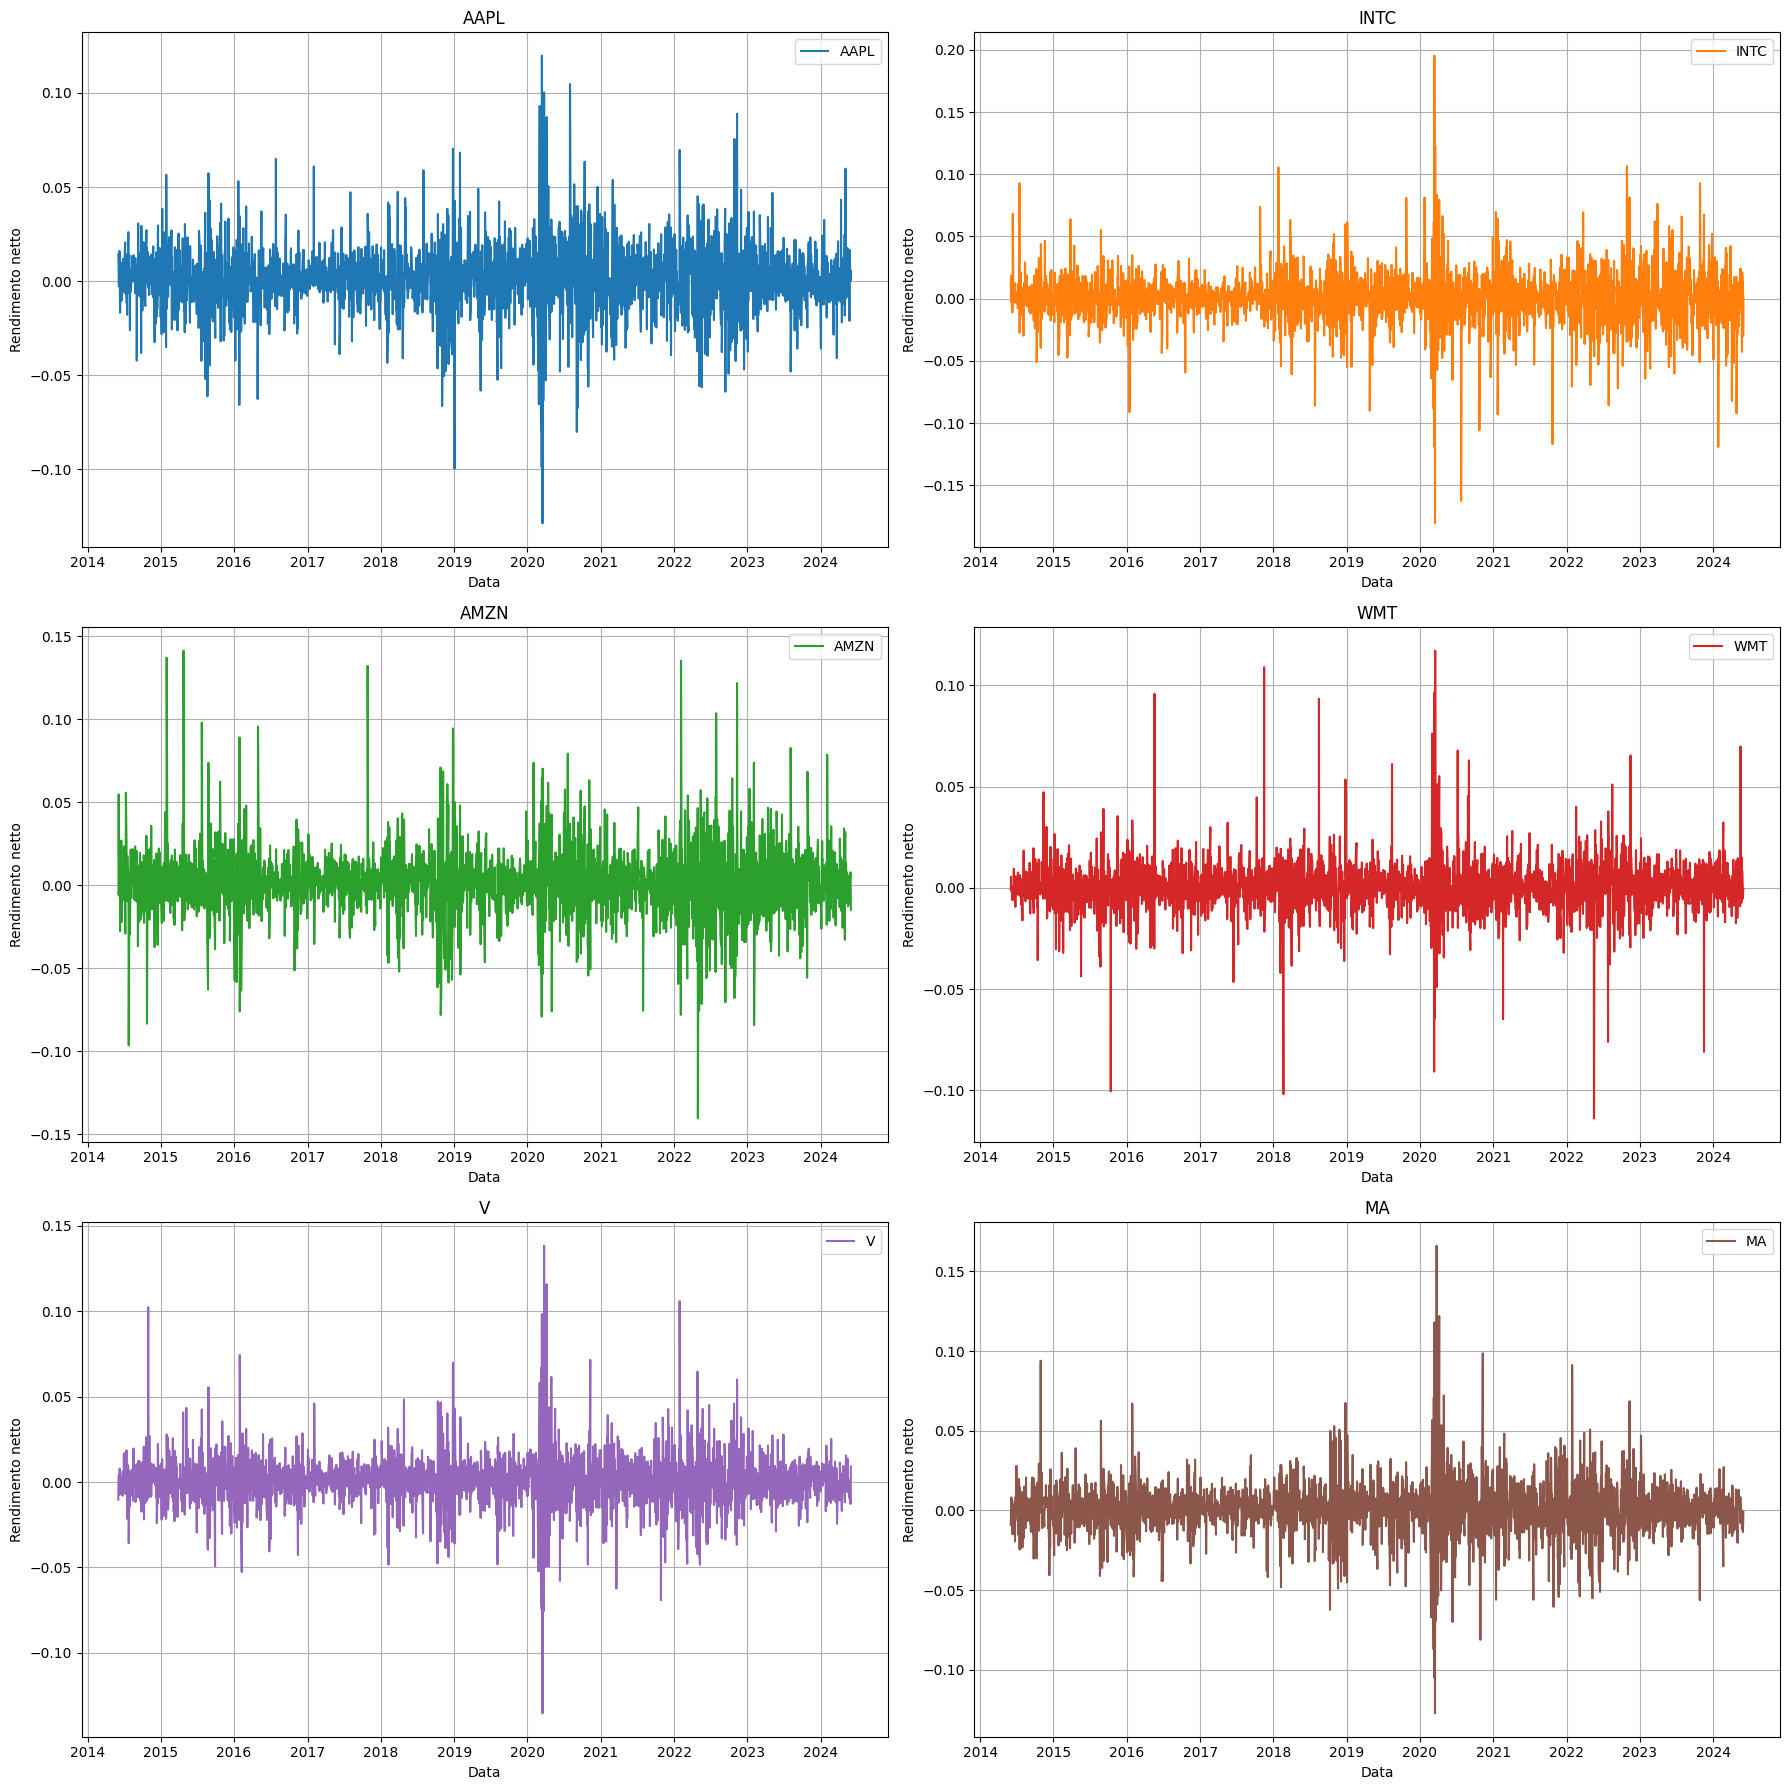

In [8]:
crea_grafici_separati(rendimenti_netti_giornalieri, 'Rendimento netto')

In [9]:
# ricavo i rendimenti lordi a partire da quelli netti
rendimenti_lordi_giornalieri = rendimenti_netti_giornalieri + 1
rendimenti_lordi_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014141,1.014674,0.994657,0.999348,0.989697,0.990915
2014-06-04,1.011419,0.997831,0.998665,1.005475,1.000520,0.999607
2014-06-05,1.003924,1.002174,1.054730,1.002463,1.003736,1.006813
2014-06-06,0.997250,1.018438,1.018852,0.998577,1.003675,1.008199
2014-06-09,1.016002,0.990770,0.993418,0.997410,0.998028,0.992126
...,...,...,...,...,...,...
2024-05-23,0.978942,0.957352,0.988642,0.993716,0.995101,0.988369
2024-05-24,1.016588,1.021277,0.998343,1.008328,1.000948,0.999934
2024-05-28,1.000053,1.011068,1.007745,0.994800,0.987213,0.986480


In [10]:
# calcolo i rendimenti cumulati come prodotto cumulativo dei rendimenti lordi
rendimenti_cumulati = rendimenti_lordi_giornalieri.cumprod()

rendimenti_cumulati

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014141,1.014674,0.994657,0.999348,0.989697,0.990915
2014-06-04,1.025722,1.012472,0.993330,1.004820,0.990212,0.990526
2014-06-05,1.029746,1.014674,1.047695,1.007295,0.993912,0.997274
2014-06-06,1.026915,1.033383,1.067446,1.005862,0.997565,1.005451
2014-06-09,1.043347,1.023844,1.060420,1.003257,0.995598,0.997534
...,...,...,...,...,...,...
2024-05-23,9.397409,1.442241,11.724517,3.117380,5.509323,6.228434
2024-05-24,9.553294,1.472927,11.705090,3.143342,5.514546,6.228020
2024-05-28,9.553798,1.489229,11.795751,3.126996,5.444030,6.143816


Visualizziamo l'andamento dei rendimenti cumulati nel corso del tempo.

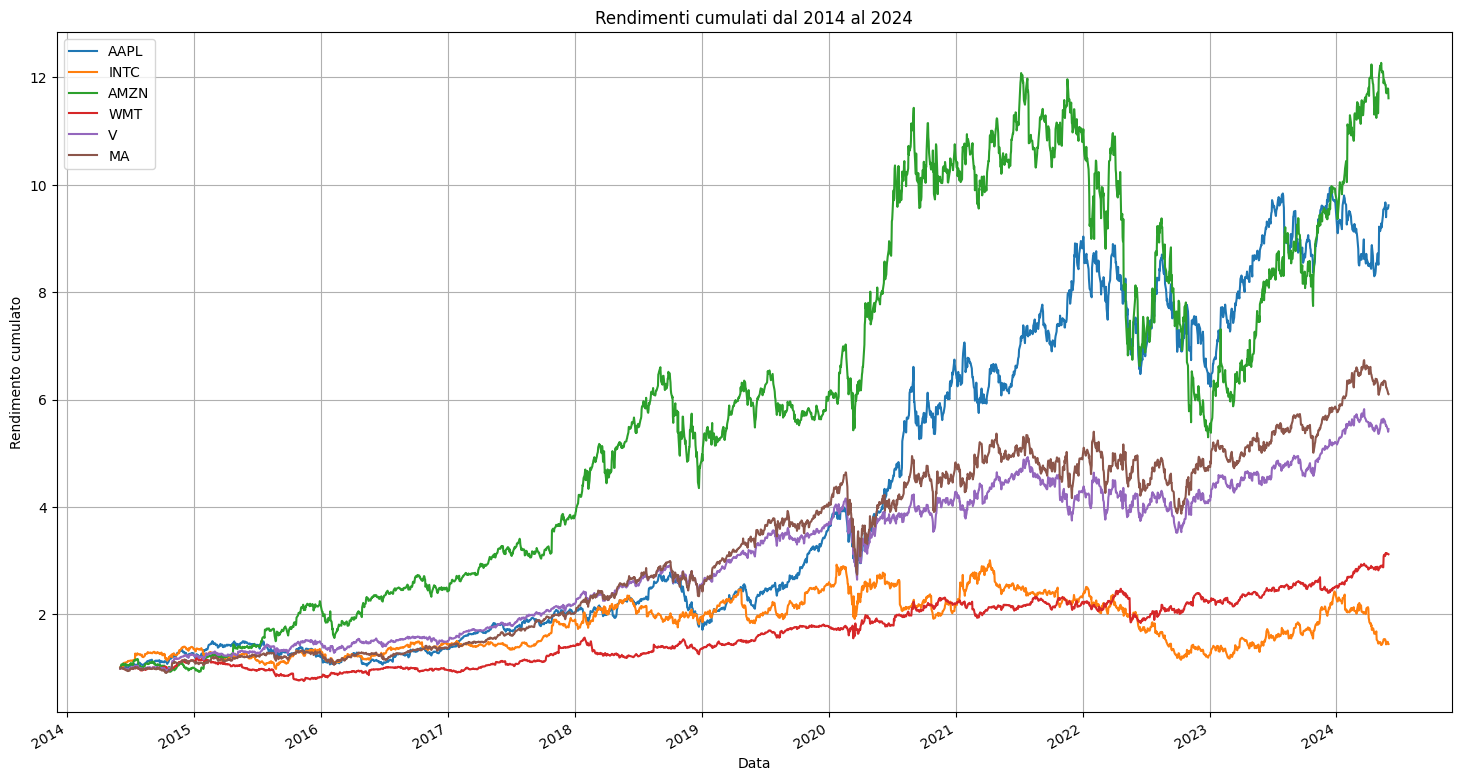

In [11]:
rendimenti_cumulati.plot(figsize=(18, 10))
plt.title('Rendimenti cumulati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Rendimento cumulato')
plt.legend()
plt.grid(True)
plt.show()

Analogamente, visualizziamo l'evoluzione della volatilità nel tempo.

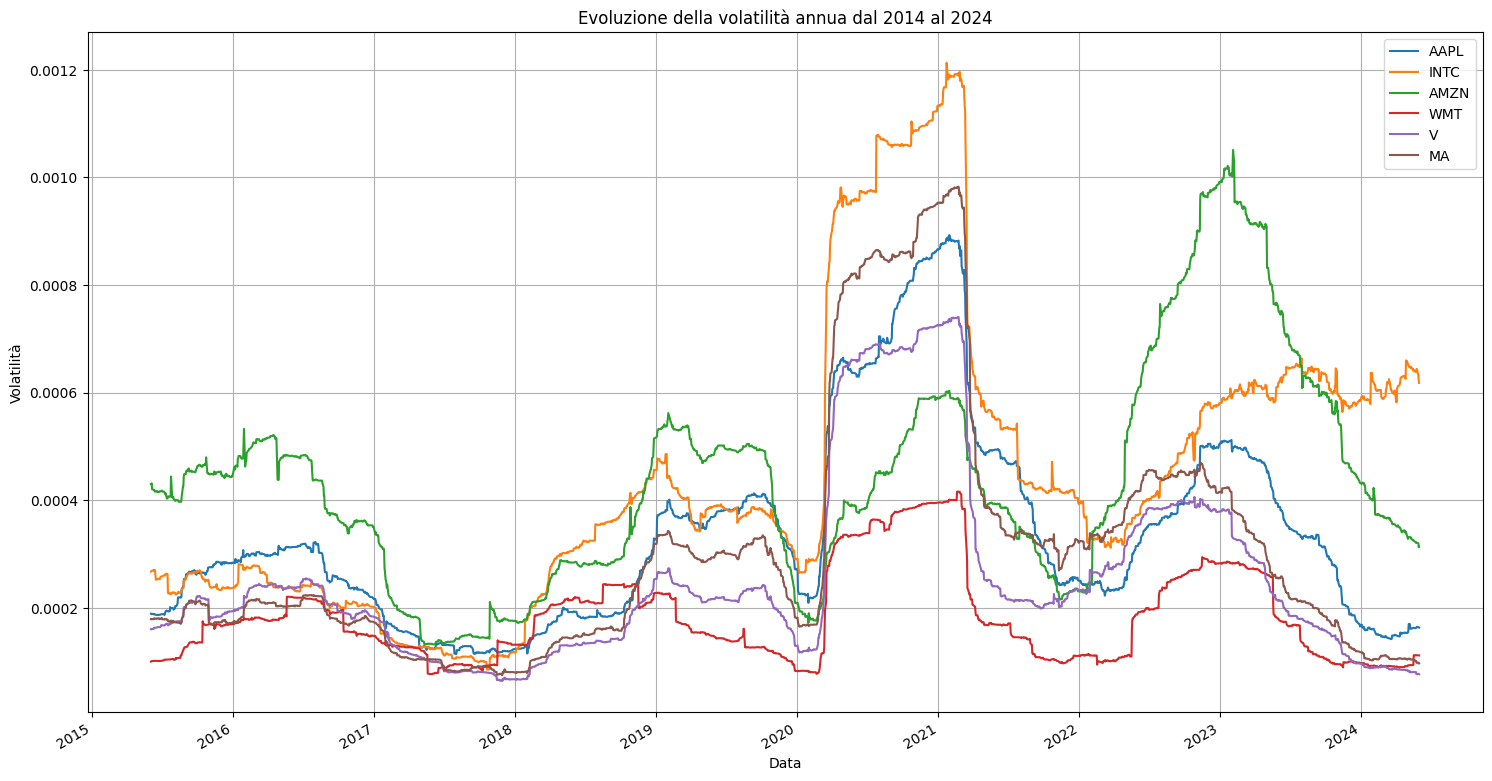

In [12]:
rendimenti_netti_giornalieri.rolling(window=252).var().plot(figsize=(18, 10))
plt.title('Evoluzione della volatilità annua dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Volatilità')
plt.legend()
plt.grid(True)
plt.show()

Ora calcoliamo il rendimento composto annuo sul periodo considerato (Compound Annual Growth Rate, CAGR).

In [13]:
numero_anni = (fine - inizio) / dt.timedelta(days=365)
CAGR = rendimenti_cumulati.iloc[-1] ** (1 / numero_anni) - 1 # sfrutto i rendimenti cumulati che ho già calcolato
CAGR.rename("CAGR", inplace=True)

CAGR

Ticker
AAPL    0.253814
INTC    0.037646
AMZN    0.277630
WMT     0.120397
V       0.184630
MA      0.198085
Name: CAGR, dtype: float64

A partire dai rendimenti lordi giornalieri ricaviamo i rendimenti logaritmici.

In [14]:
rendimenti_logaritmici = np.log(rendimenti_lordi_giornalieri) # log è il logaritmo naturale
rendimenti_logaritmici

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014042,0.014567,-0.005357,-0.000652,-0.010356,-0.009127
2014-06-04,0.011354,-0.002172,-0.001336,0.005460,0.000520,-0.000393
2014-06-05,0.003916,0.002172,0.053285,0.002460,0.003729,0.006790
2014-06-06,-0.002754,0.018271,0.018677,-0.001424,0.003669,0.008165
2014-06-09,0.015875,-0.009273,-0.006604,-0.002594,-0.001974,-0.007905
...,...,...,...,...,...,...
2024-05-23,-0.021283,-0.043584,-0.011423,-0.006303,-0.004911,-0.011700
2024-05-24,0.016452,0.021053,-0.001658,0.008294,0.000948,-0.000066
2024-05-28,0.000053,0.011007,0.007716,-0.005214,-0.012870,-0.013612


Vediamo il livello di correlazione che sussiste tra i rendimenti dei titoli appartenenti allo stesso settore.

In [15]:
rendimenti_netti_giornalieri[tickers_settore1].corr()

Ticker,AAPL,INTC
Ticker,,
AAPL,1.000000,0.512803
INTC,0.512803,1.000000


In [16]:
rendimenti_netti_giornalieri[tickers_settore2].corr()

Ticker,AMZN,WMT
Ticker,,
AMZN,1.000000,0.250431
WMT,0.250431,1.000000


In [17]:
rendimenti_netti_giornalieri[tickers_settore3].corr()

Ticker,V,MA
Ticker,,
V,1.000000,0.895385
MA,0.895385,1.000000


Per ciascun titolo visualizziamo i grafici diagnostici a tre sezioni.

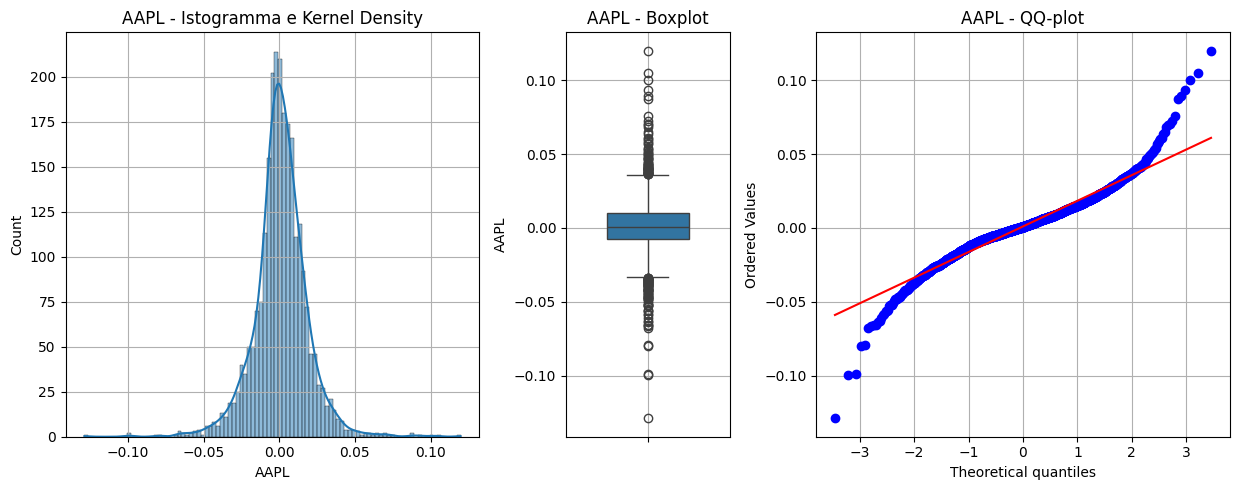

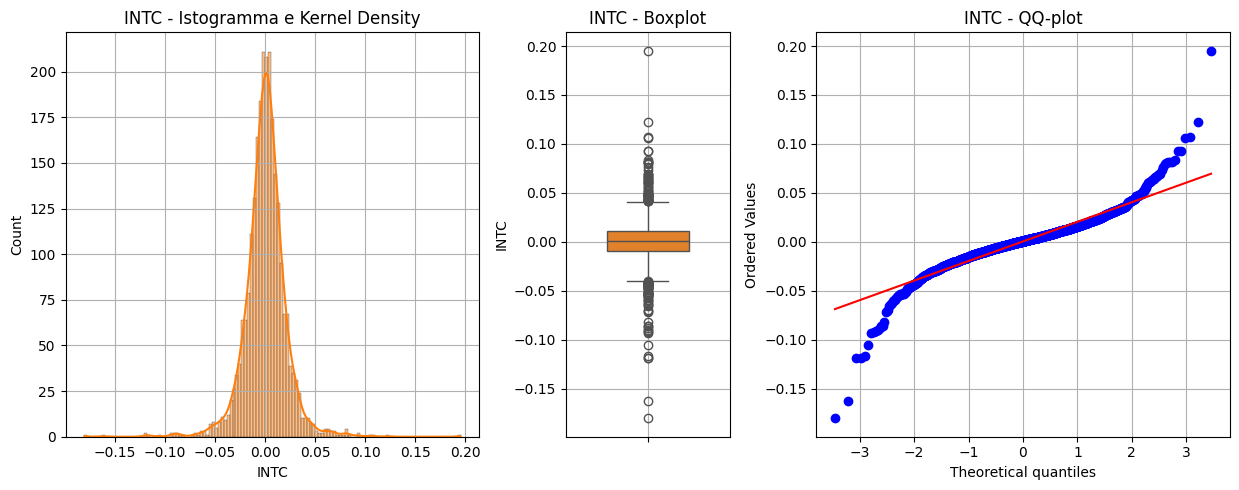

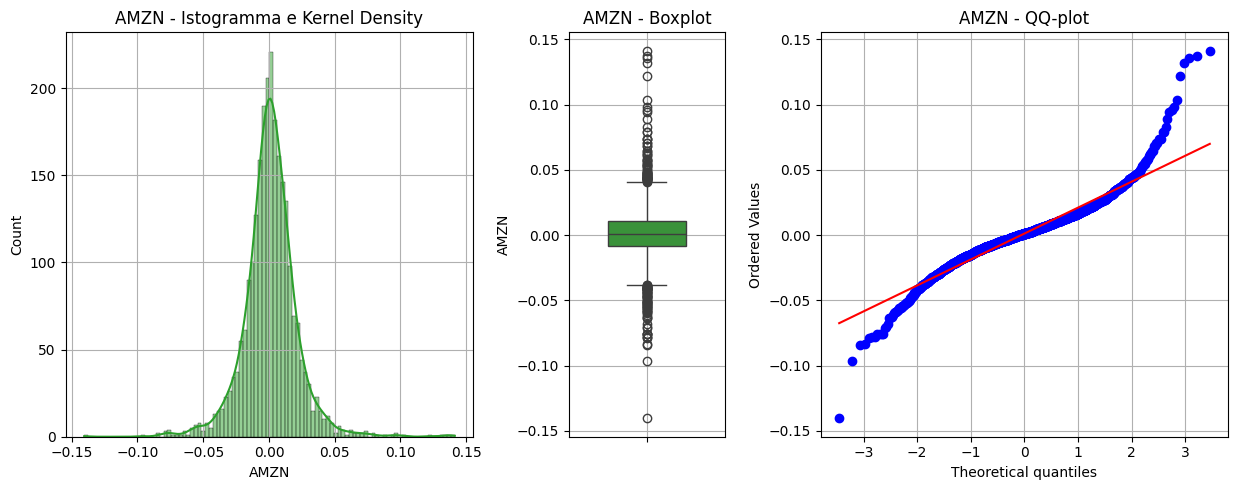

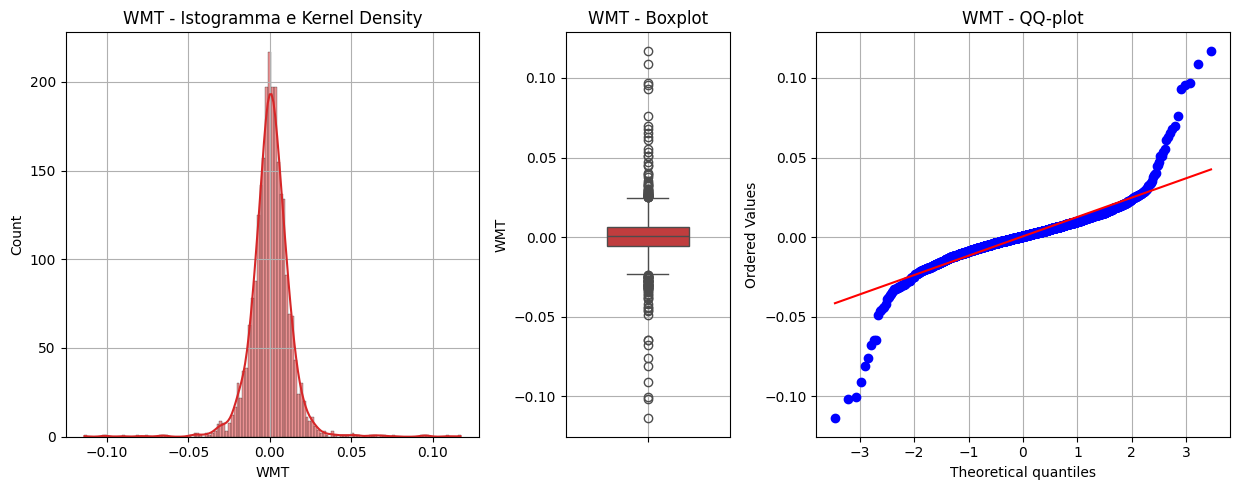

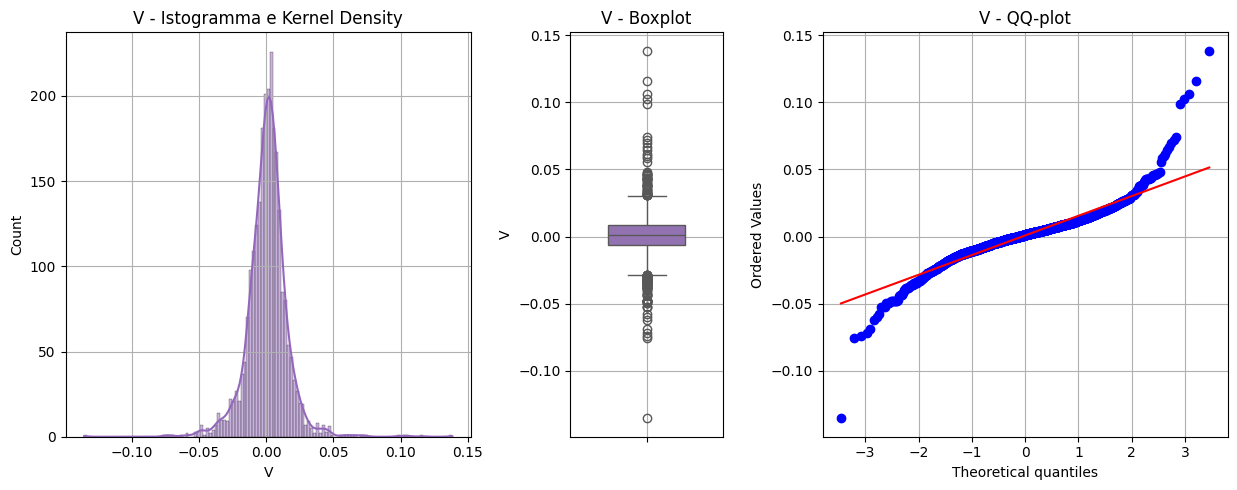

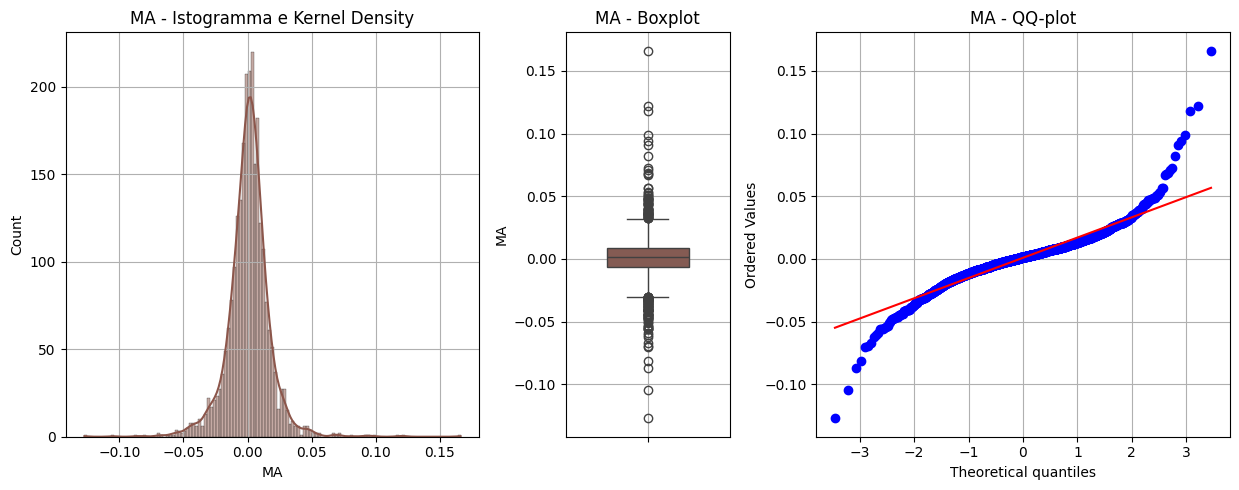

In [18]:
def crea_grafici_diagnostici(dataframe, ticker, colore):
    plt.figure(figsize=(15, 5))

    # Istogramma e kernel density
    plt.subplot2grid((1, 6), (0, 0), colspan=2, rowspan=1)
    sns.histplot(data=dataframe[ticker], kde=True, color=colore)
    plt.title(f'{ticker} - Istogramma e Kernel Density')
    plt.grid(True)

    # Boxplot
    plt.subplot2grid((1, 6), (0, 2), colspan=1, rowspan=1)
    sns.boxplot(data=dataframe[ticker], color=colore, width=0.5)
    plt.title(f'{ticker} - Boxplot')
    plt.grid(True)

    # QQ-plot
    plt.subplot2grid((1, 6), (0, 3), colspan=2, rowspan=1)
    stats.probplot(dataframe[ticker], dist="norm", plot=plt)
    plt.title(f'{ticker} - QQ-plot')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Esegui la funzione per ciascun titolo
for i, ticker in enumerate(tickers):
    colore = mappa_colori(i % 10)  # L'operazione modulo assicura che non superiamo l'indice massimo della mappa
    crea_grafici_diagnostici(rendimenti_netti_giornalieri, ticker, colore)

Calcoliamo le statistiche descrittive univariate dei rendimenti netti giornalieri.

In [19]:
statistiche_rendimenti_netti_giornalieri = rendimenti_netti_giornalieri.describe()

# oltre alle statistiche restituite da describe() aggiungo varianza, kurtosi e skewness
varianza = pd.Series(rendimenti_netti_giornalieri.var()).to_frame().T
kurtosi = pd.Series(rendimenti_netti_giornalieri.kurtosis()).to_frame().T
skewness = pd.Series(rendimenti_netti_giornalieri.skew()).to_frame().T
varianza.rename(index={0: 'var'}, inplace=True)
kurtosi.rename(index={0: 'kurt'}, inplace=True)
skewness.rename(index={0: 'skew'}, inplace=True)

statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, varianza])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, kurtosi])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, skewness])

statistiche_rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,0.001059,0.000370,0.001187,0.000539,0.000793,0.000863
std,0.017841,0.021046,0.020638,0.013181,0.015427,0.016970
min,-0.128647,-0.180415,-0.140494,-0.113757,-0.135472,-0.127255
25%,-0.007324,-0.009571,-0.008609,-0.005382,-0.006481,-0.006842
50%,0.000821,0.000795,0.001153,0.000576,0.001316,0.001395
75%,0.010141,0.010663,0.011145,0.006606,0.008236,0.008719
max,0.119808,0.195213,0.141311,0.117085,0.138426,0.166109
var,0.000318,0.000443,0.000426,0.000174,0.000238,0.000288
kurt,5.360352,10.311218,6.337522,16.261155,10.399205,10.021972


Ora vediamo la matrice di covarianza e la matrice di correlazione.

In [20]:
rendimenti_netti_giornalieri.cov() # matrice di covarianza

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,0.000318,0.000193,0.000203,0.000075,0.000158,0.000178
INTC,0.000193,0.000443,0.000173,0.000076,0.000150,0.000169
AMZN,0.000203,0.000173,0.000426,0.000068,0.000149,0.000169
WMT,0.000075,0.000076,0.000068,0.000174,0.000059,0.000064
V,0.000158,0.000150,0.000149,0.000059,0.000238,0.000234
MA,0.000178,0.000169,0.000169,0.000064,0.000234,0.000288


In [21]:
rendimenti_netti_giornalieri.corr() # matrice di correlazione

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,1.000000,0.512803,0.551242,0.320541,0.572258,0.586861
INTC,0.512803,1.000000,0.397253,0.274462,0.461147,0.474221
AMZN,0.551242,0.397253,1.000000,0.250431,0.466580,0.483197
WMT,0.320541,0.274462,0.250431,1.000000,0.289393,0.284193
V,0.572258,0.461147,0.466580,0.289393,1.000000,0.895385
MA,0.586861,0.474221,0.483197,0.284193,0.895385,1.000000


Vediamo com'è stato l'andamento nel tempo della correlazione tra titoli dello stesso settore.

In [22]:
def andamento_correlazione_rendimenti(tickers_settore, nome_settore, colore):
    # Calcola la correlazione tra i titoli del settore
    correlazione = rendimenti_netti_giornalieri[tickers_settore[0]].rolling(window=252).corr(rendimenti_netti_giornalieri[tickers_settore[1]])

    # Visualizza l'andamento della correlazione su un grafico
    fig, ax = plt.subplots(figsize=(12, 6))
    correlazione.plot(label=nome_settore, ax=ax, color=colore)

    ax.axhline(rendimenti_netti_giornalieri.corr().loc[tickers_settore[0], tickers_settore[1]], c='r')
    plt.legend()
    plt.title(f'Andamento della correlazione nel tempo dei titoli per il settore {nome_settore}')
    plt.xlabel('Data')
    plt.ylabel('Correlazione')
    plt.grid(True)
    plt.show()

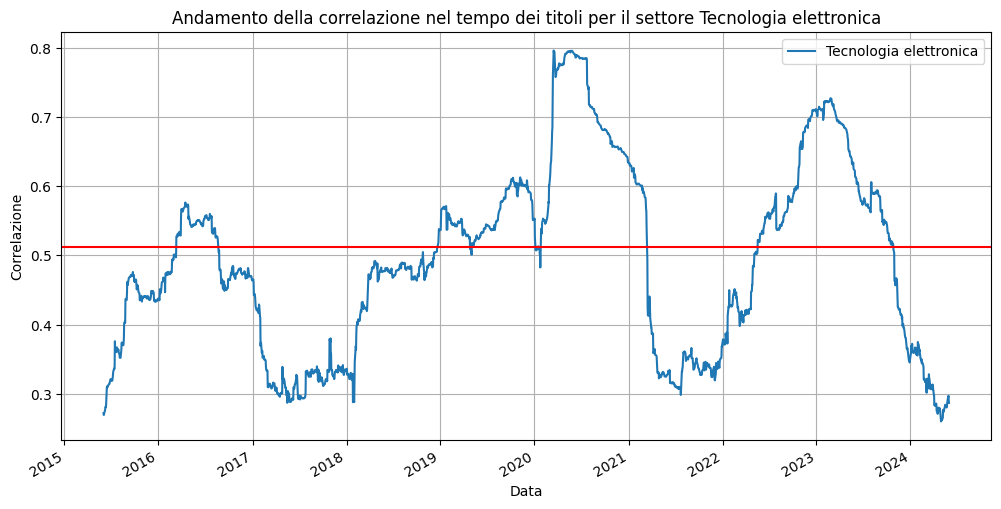

In [23]:
andamento_correlazione_rendimenti(tickers_settore1, settore_1, mappa_colori(0))

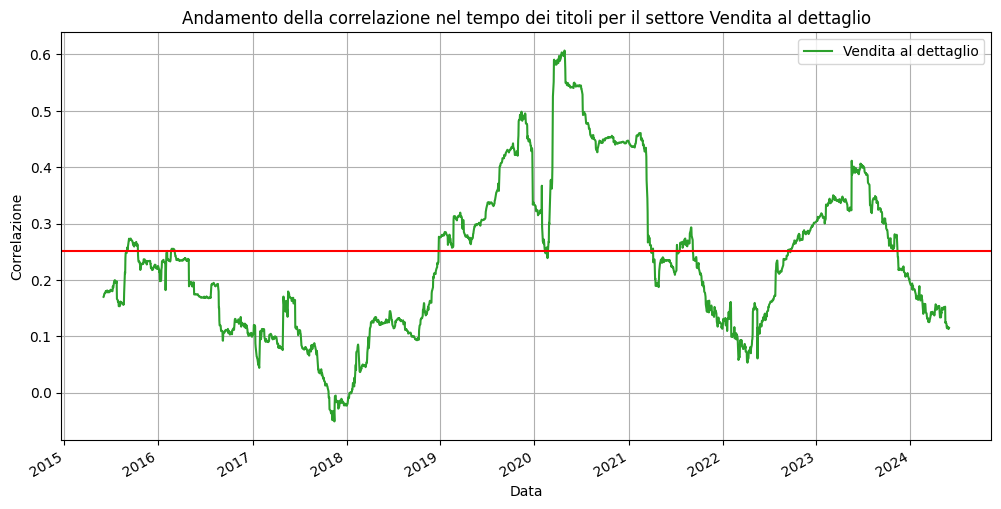

In [24]:
andamento_correlazione_rendimenti(tickers_settore2, settore_2, mappa_colori(2))

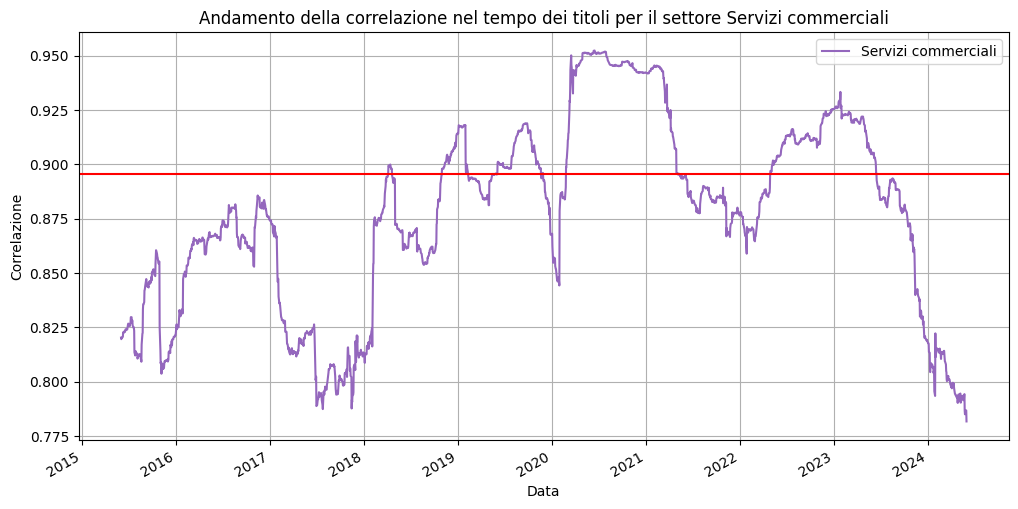

In [25]:
andamento_correlazione_rendimenti(tickers_settore3, settore_3, mappa_colori(4))

Attraverso degli scatter plot osserviamo la dispersione dei rendimenti mettendo a confronto i titoli dello stesso settore. 

In [26]:
colore_neutro_chiaro = '#333333'
colore_neutro_scuro = '#666666'
def crea_scatter_plot(dataframe, settore):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(dataframe[settore[0]], dataframe[settore[1]], color=colore_neutro_chiaro)
    ax.set_xlim(min(dataframe[settore[0]]), max(dataframe[settore[1]]))
    ax.autoscale(False)
    ax.vlines(0, -10, 10, color=colore_neutro_scuro)
    ax.hlines(0, -10, 10, color=colore_neutro_scuro)
    ax.plot((-10,10),(-10,10), color=colore_neutro_scuro)
    ax.set_xlabel(settore[0])
    ax.set_ylabel(settore[1])
    plt.grid(True)

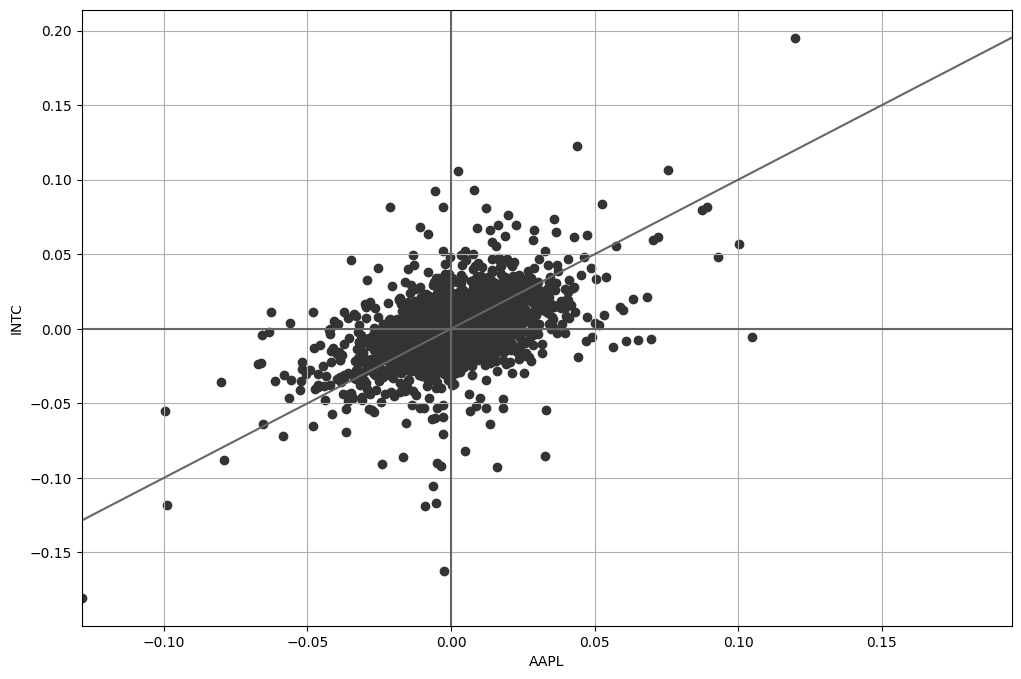

In [27]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore1)

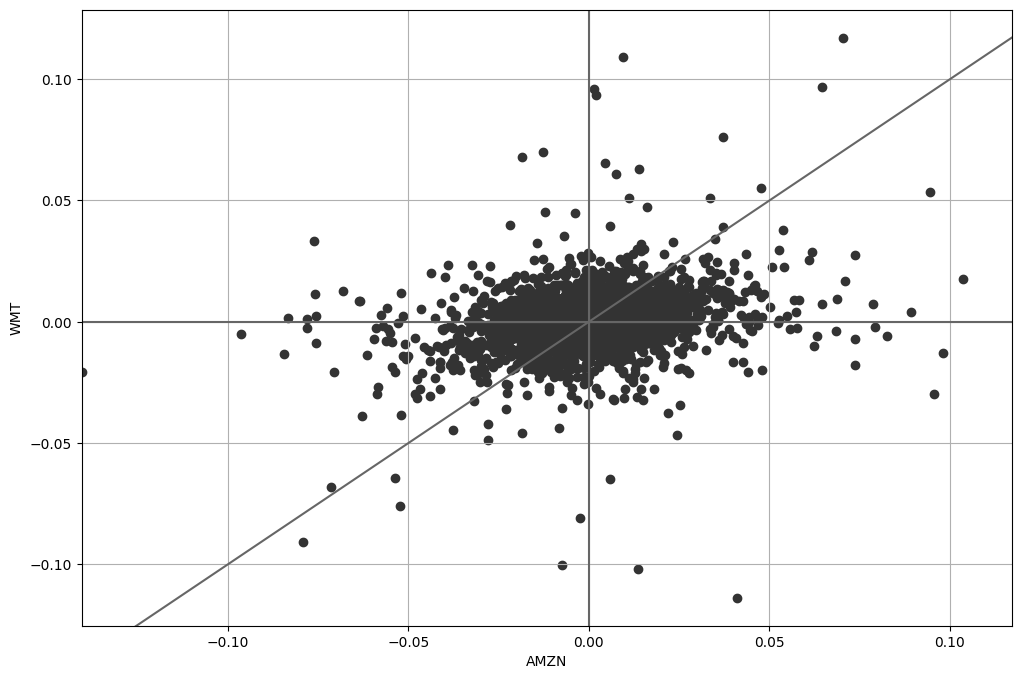

In [28]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore2)

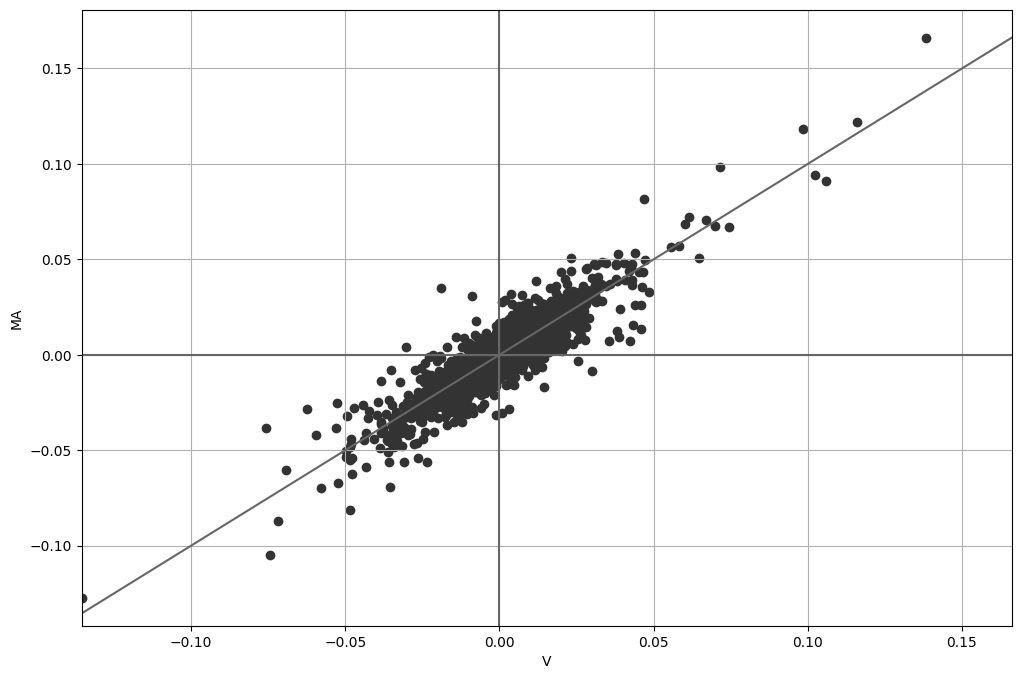

In [29]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore3)

## 3. Analisi di previsione

Costruiamo un modello ARIMA per effettuare previsioni sulla serie dei prezzi di ciascun titolo.

Per prima cosa proviamo a vedere se la serie dei prezzi risulta essere stazionaria; per farlo, utilizziamo il test statistico Augmented Dickey Fuller.

Ovviamente è quasi impossibile che la serie dei prezzi possa essere stazionaria: per questo motivo, l'iperparametro d del modello ARIMA è fondamentale per la buona riuscita della stima.


In [30]:
risultati_adf = []

for ticker in tickers:
    risultato = adfuller(prezzi_chiusura_giornalieri[ticker])
    risultati_adf.append({
        'Ticker': ticker,
        'ADF Statistic': risultato[0],
        'p-value': risultato[1],
        'Critical Value (1%)': risultato[4]['1%'],
        'Critical Value (5%)': risultato[4]['5%'],
        'Critical Value (10%)': risultato[4]['10%']
    })

df_risultati_adf = pd.DataFrame(risultati_adf).set_index('Ticker')
display(df_risultati_adf)

,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Ticker,,,,,
AAPL,0.033611,0.961225,-3.432971,-2.862698,-2.567386
INTC,-2.184326,0.211983,-3.432961,-2.862694,-2.567384
AMZN,-0.651671,0.858874,-3.432980,-2.862702,-2.567389
WMT,0.590038,0.987367,-3.432961,-2.862694,-2.567384
V,-0.389447,0.911846,-3.432968,-2.862697,-2.567386
MA,-0.344425,0.918973,-3.432968,-2.862697,-2.567386


Dividiamo i dati che abbiamo a disposizione in tre diversi dataset:
- training set, che utilizzeremo per addestrare il modello
- validation set, che utilizzeremo per individuare i migliori iperparametri da adottare
- test set, che utilizzeremo per confrontare le previsioni e calcolare l'errore commesso

In [31]:
mesi_training_set = 80
mesi_validation_set = 30
mesi_test_set = 10

training_set = prezzi_chiusura_giornalieri.iloc[:(mesi_training_set * 21)].copy()
validation_set = prezzi_chiusura_giornalieri.iloc[(mesi_training_set * 21):((mesi_training_set + mesi_validation_set) * 21)].copy()
test_set = prezzi_chiusura_giornalieri.iloc[((mesi_training_set + mesi_validation_set) * 21):].copy()

training_set = training_set.asfreq('D')
validation_set = validation_set.asfreq('D')
test_set = test_set.asfreq('D')

training_set.dropna(inplace=True)
validation_set.dropna(inplace=True)
test_set.dropna(inplace=True)

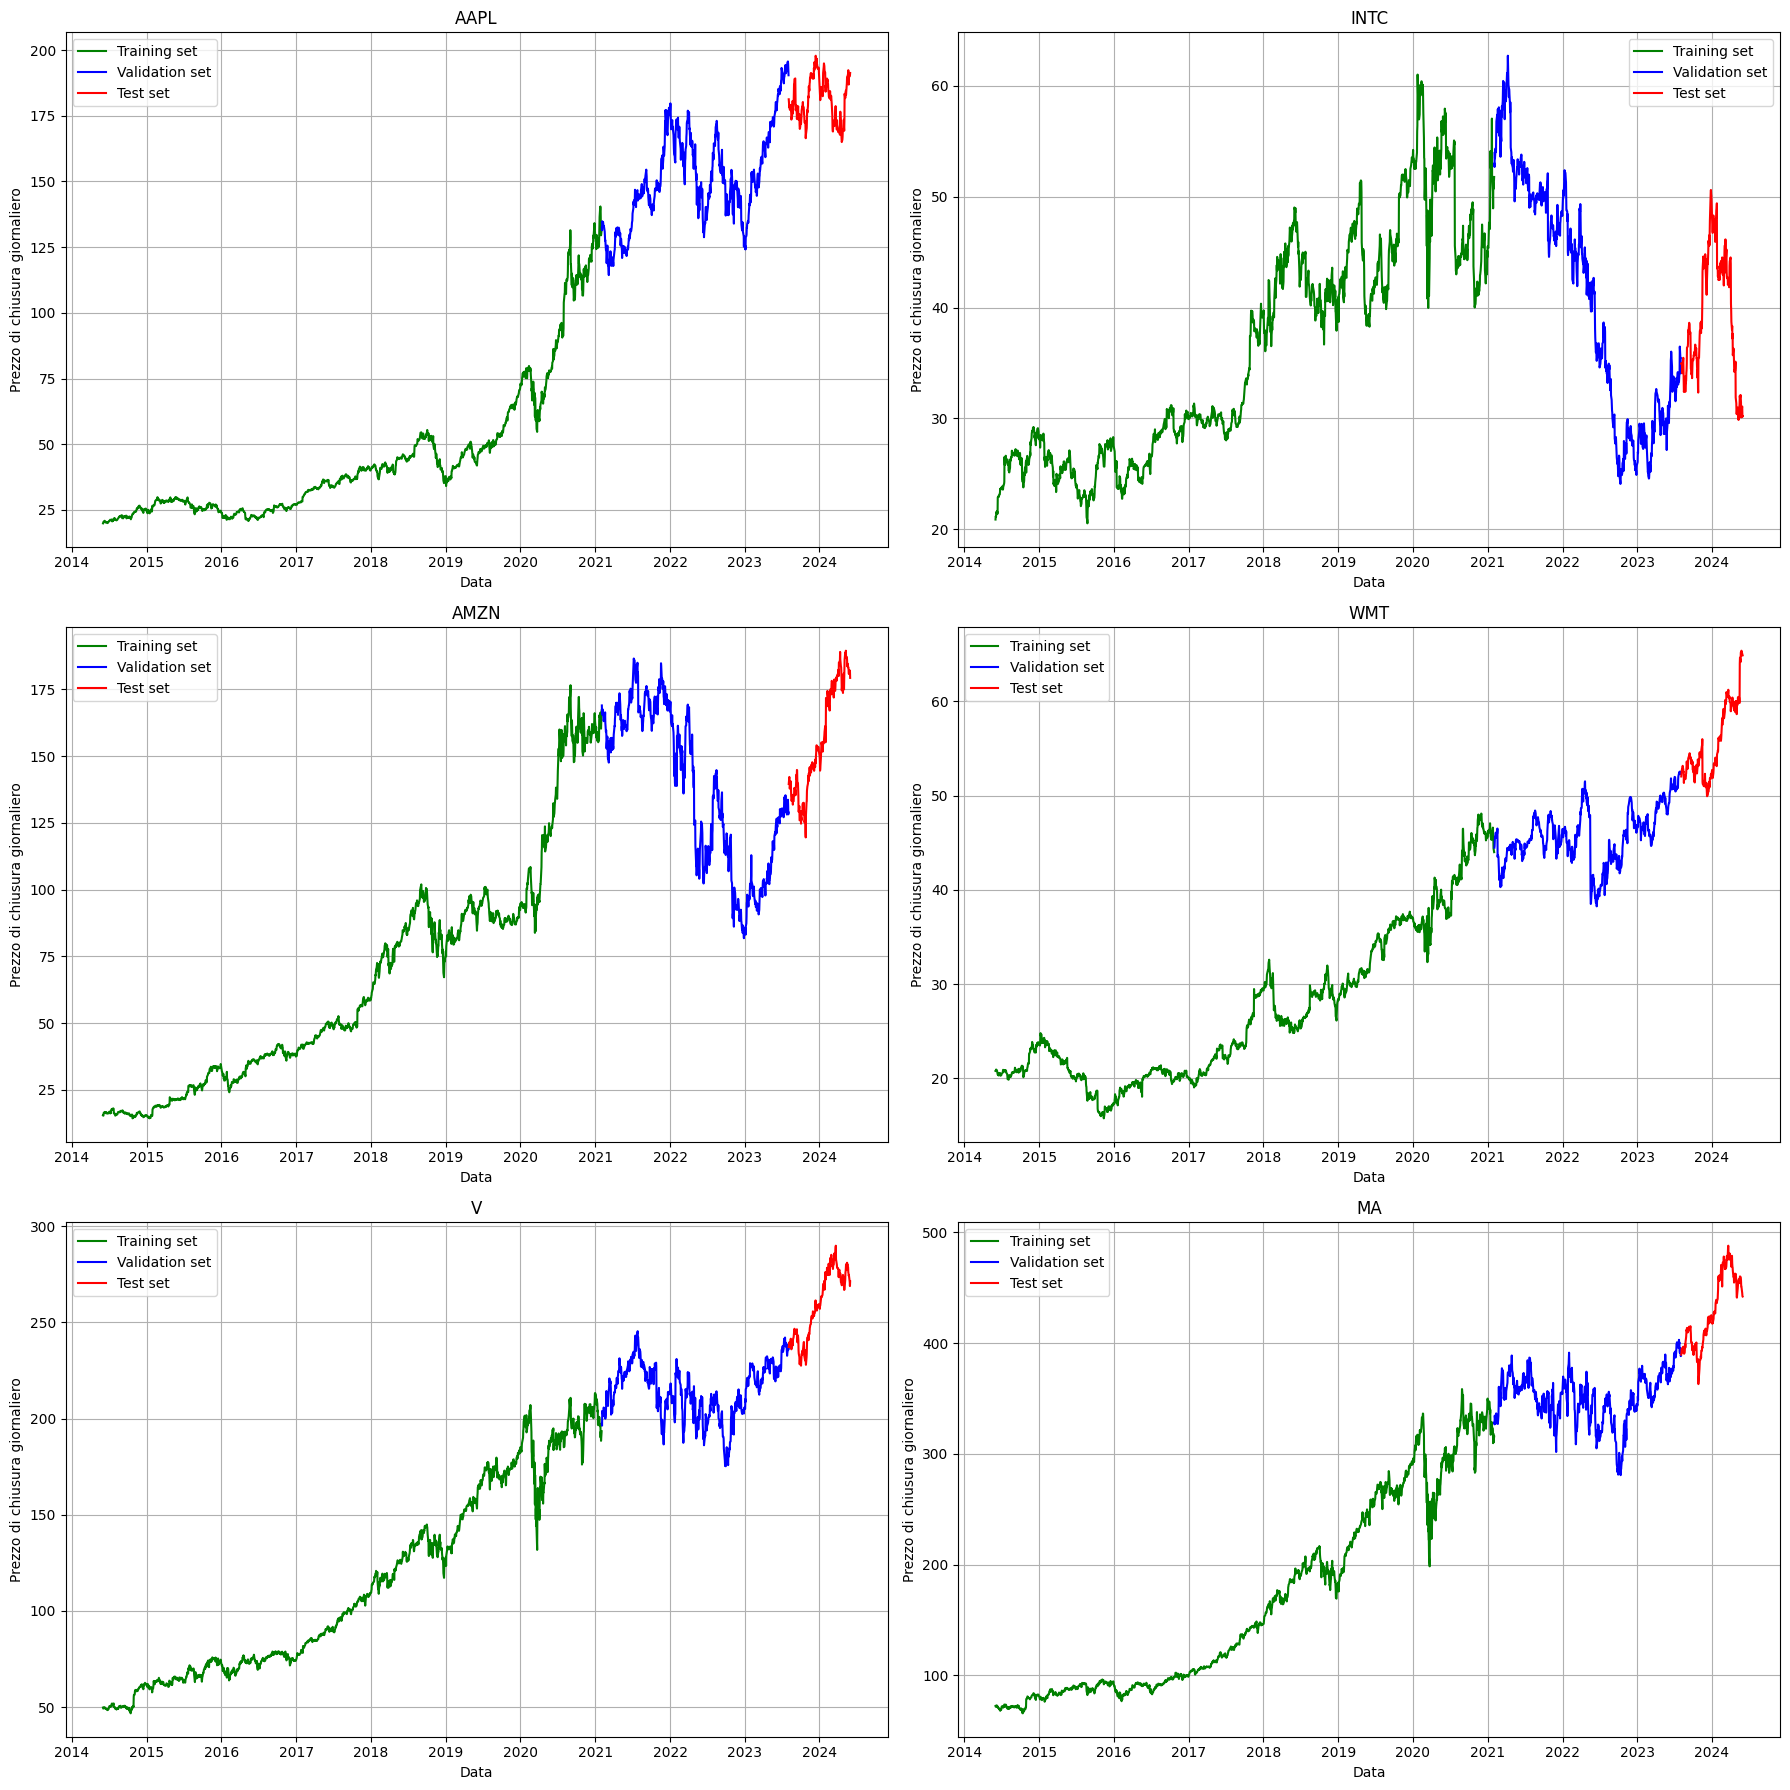

In [32]:
def visualizza_data_set(training_set, validation_set, test_set, label):
    tickers = training_set.columns
    n = len(tickers)
    rows = (n + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(18, 6 * rows))

    if n % 2 != 0:
        axes[-1, -1].axis('off')

    for i, ticker in enumerate(tickers):
        ax = axes[i // 2, i % 2]

        ax.plot(training_set.index, training_set[ticker], label='Training set', color='green')
        ax.plot(validation_set.index, validation_set[ticker], label='Validation set', color='blue')
        ax.plot(test_set.index, test_set[ticker], label='Test set', color='red')
        
        ax.set_title(f'{ticker}')
        ax.set_xlabel('Data')
        ax.set_ylabel(label)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
visualizza_data_set(training_set, validation_set, test_set, label='Prezzo di chiusura giornaliero')

Per prima cosa dobbiamo individuare la miglior terna di iperparametri con cui addestrare il modello: per farlo proviamo ogni terna di iperparametri e vediamo in quale caso viene generato l'errore più basso.

In [33]:

import warnings
warnings.filterwarnings("ignore")

# NB: non ho fatto un for con tutti i ticker per evitare tempi di esecuzione biblici
ticker_previsione = 'AAPL' # modificare questa variabile per scegliere il ticker su cui fare la previsione

# Definizione delle terne di iperparametri
p_values = [0, 1, 2, 3, 4]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4]

param_combinations = list(itertools.product(p_values, d_values, q_values))

best_score = float('inf')
best_params = None

for (p, d, q) in param_combinations:
    try:
        print(f"Testing ARIMA({p}, {d}, {q})...")
        
        model = ARIMA(training_set[ticker_previsione], order=(p, d, q))
        model_fit = model.fit()

        # Fai previsioni sul validation set
        forecast = model_fit.forecast(steps=len(validation_set))
        predictions = pd.Series(forecast.values, index=validation_set.index)

        # Calcola l'errore
        mse = mean_squared_error(validation_set[ticker_previsione], predictions)

        # Se l'errore è il migliore fino ad ora, salva i parametri e il modello
        if mse < best_score:
            best_score = mse
            best_params = (p, d, q)

    except Exception as e:
        print(f"Si è verificato un errore per ARIMA({p}, {d}, {q}): {str(e)}")
        continue

print(f"Migliori iperparametri: {best_params} con RMSE: {math.sqrt(best_score)}")

Testing ARIMA(0, 0, 0)...
Testing ARIMA(0, 0, 1)...
Testing ARIMA(0, 0, 2)...
Testing ARIMA(0, 0, 3)...
Testing ARIMA(0, 0, 4)...
Testing ARIMA(0, 1, 0)...
Testing ARIMA(0, 1, 1)...
Testing ARIMA(0, 1, 2)...
Testing ARIMA(0, 1, 3)...
Testing ARIMA(0, 1, 4)...
Testing ARIMA(0, 2, 0)...
Testing ARIMA(0, 2, 1)...
Testing ARIMA(0, 2, 2)...
Testing ARIMA(0, 2, 3)...
Testing ARIMA(0, 2, 4)...
Testing ARIMA(1, 0, 0)...
Testing ARIMA(1, 0, 1)...
Testing ARIMA(1, 0, 2)...
Testing ARIMA(1, 0, 3)...
Testing ARIMA(1, 0, 4)...
Testing ARIMA(1, 1, 0)...
Testing ARIMA(1, 1, 1)...
Testing ARIMA(1, 1, 2)...
Testing ARIMA(1, 1, 3)...
Testing ARIMA(1, 1, 4)...


KeyboardInterrupt: 

Una volta individuata la miglior terna di iperparametri possiamo procedere all'addestramento finale, costruendo il modello predittivo con cui effettuare previsioni sui dati di test. <br>
Le previsioni vengono effettuate giorno per giorno: ogni giorno il modello agisce su tutti i dati (compreso il valore corrente), al fine di produrre una previsione puntuale sul prezzo del giorno successivo.

In [ ]:
if best_params is not None:
    
    # Estrai i dati univariati da training_set, validation_set e test_set
    training_data = np.array(training_set[ticker_previsione])
    validation_data = np.array(validation_set[ticker_previsione])
    testing_data = np.array(test_set[ticker_previsione])
    
    # Combina training_data e validation_data per il modello ARIMA
    combined_data = np.concatenate([training_data, validation_data])
    
    arima_model = ARIMA(combined_data, order=best_params).fit()
    
    # Inizializza la lista per memorizzare le previsioni
    model_predictions = []
    
    # Loop sul set di test
    for i in range(len(test_set)):
        print('Calcolo in corso: previsione ' + str(i) + ' su ' + str(len(test_set)))
        # Prevedi il prossimo valore
        output = arima_model.forecast(steps=1)
        model_predictions.append(output)
        
        # Ottieni il valore effettivo del test
        actual_test_value = testing_data[i]
        
        # Aggiungi il valore effettivo ai dati di addestramento
        combined_data = np.append(combined_data, actual_test_value)
        
        # Rifai il fit del modello con i dati di addestramento aggiornati
        arima_model = ARIMA(combined_data, order=best_params).fit()
    
    # Converti le previsioni del modello in un array numpy
    model_predictions = np.array(model_predictions)
    
    # Calcola l'errore sul test set
    rmse_test = math.sqrt(mean_squared_error(test_set[ticker_previsione], model_predictions))
    print(f"RMSE on test set: {rmse_test}")
    
    # Visualizza sul grafico le previsioni e i dati effettivi
    plt.figure(figsize=(14, 7))
    plt.plot(test_set.index, test_set[ticker_previsione], label='Prezzo effettivo')
    plt.plot(test_set.index, model_predictions, label='Prezzo previsto')
    plt.title('Previsione dei prezzi di chiusura giornalieri con ARIMA')
    plt.xlabel('Data')
    plt.ylabel(f'Prezzo di {ticker_previsione}')
    plt.legend()
    plt.grid(True)
    plt.show()

Per poter fare un confronto con la previsione del modello ARIMA, proviamo a vedere di quanto sbaglieremmo se prevedessimo il prezzo del giorno successivo come il prezzo del giorno corrente.

In [ ]:
# Estrai i dati univariati da training_set, validation_set e test_set
training_data = np.array(training_set[ticker_previsione])
validation_data = np.array(validation_set[ticker_previsione])
testing_data = np.array(test_set[ticker_previsione])

# Inizializza la lista per memorizzare le previsioni
model_predictions = []

# Loop sul set di test
for i in range(len(test_set)):
    # Prevedi il prossimo valore
    if(i == 0):
        output = validation_data[-1]
    else:
        output = testing_data[i-1]
    
    model_predictions.append(output)
    
    # Ottieni il valore effettivo del test
    actual_test_value = testing_data[i]

# Converti le previsioni del modello in un array numpy
model_predictions = np.array(model_predictions)

# Calcola l'errore sul test set
rmse_test = math.sqrt(mean_squared_error(test_set[ticker_previsione], model_predictions))
print(f"RMSE on test set: {rmse_test}")

# Visualizza sul grafico le previsioni e i dati effettivi
plt.figure(figsize=(14, 7))
plt.plot(test_set.index, test_set[ticker_previsione], label='Prezzo effettivo')
plt.plot(test_set.index, model_predictions, label='Prezzo previsto')
plt.title('Previsione dei prezzi di chiusura giornalieri con ARIMA')
plt.xlabel('Data')
plt.ylabel(f'Prezzo di {ticker_previsione}')
plt.legend()
plt.grid(True)
plt.show()

## 4. Strategie di trading e backtesting

Procediamo ora con la costruzione di una strategia di trading.

L'idea che si vuole analizzare è quella di combinare l'utilizzo delle medie mobili esponenziali e dell'indice RSI per generare segnali d'acquisto: utilizzando entrambi gli indicatori è possibile tenere conto sia del trend (catturato dalle medie mobili esponenziali) sia del momentum (catturato dall'indice RSI).

In [ ]:
ticker_strategia = 'AMZN' # ticker su cui applicare la strategia

indicatori_trading  = prezzi_chiusura_giornalieri[ticker_strategia].copy()
indicatori_trading.rename('Chiusura aggiustata', inplace=True)
indicatori_trading = indicatori_trading.to_frame()

indicatori_trading['EMA20'] = indicatori_trading['Chiusura aggiustata'].ewm(span=20, adjust=False).mean() # media mobile esponenziale a 20 giorni
indicatori_trading['EMA50'] = indicatori_trading['Chiusura aggiustata'].ewm(span=50, adjust=False).mean() # media mobile esponenziale a 50 giorni

In [ ]:
def calcola_RSI(data, window=14):
    delta = data['Chiusura aggiustata'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

indicatori_trading['RSI'] = calcola_RSI(indicatori_trading) # indicatore RSI
indicatori_trading.dropna(inplace=True)

indicatori_trading

In [ ]:
# Creazione dei grafici
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Grafico del prezzo di chiusura e delle medie mobili
ax1.plot(indicatori_trading.index, indicatori_trading['Chiusura aggiustata'], label='Chiusura aggiustata')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA20'], label='EMA 20 giorni')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA50'], label='EMA 50 giorni')
ax1.set_title('Prezzo di chiusura e medie mobili esponenziali')
ax1.set_ylabel('Prezzo')
ax1.legend()
ax1.grid(True)

# Grafico dell'indicatore RSI
ax2.plot(indicatori_trading.index, indicatori_trading['RSI'], label='RSI', color='orange')
ax2.axhline(70, color='black', linestyle='--', linewidth=1)
ax2.axhline(30, color='black', linestyle='--', linewidth=1)
ax2.set_title('Indicatore RSI')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Data')
ax2.legend()
ax2.grid(True)

plt.show()

Dopo aver calcolato gli indicatori di cui abbiamo bisogno, procediamo con l'applicazione della strategia.

Secondo la strategia viene generato un __segnale di acquisto__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dal basso verso l'alto la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al rialzo
- l'indice RSI supera 50, confermando che il trend rialzista è abbastanza intenso

Secondo la strategia viene generato un __segnale di vendita__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dall'alto verso il basso la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al ribasso
- l'indice RSI scende sotto 50, confermando che il trend ribassista è abbastanza intenso

In [ ]:
strategia_trading = indicatori_trading.copy()

condizione_acquisto = ((strategia_trading['EMA20'] > strategia_trading['EMA50']) &
                       (strategia_trading['RSI'] > 50))
                      
condizione_vendita = ((strategia_trading['EMA20'] < strategia_trading['EMA50']) &
                      (strategia_trading['RSI'] < 50))

# inizializza tutte le posizioni a 0
strategia_trading['Posizione'] = 0  

# Imposta le posizioni a 1 quando si verifica la condizione di acquisto
strategia_trading.loc[condizione_acquisto, 'Posizione'] = 1

# Imposta le posizioni a 0 quando si verifica la condizione di vendita
strategia_trading.loc[condizione_vendita, 'Posizione'] = 0

strategia_trading

In [ ]:
temp_rendimento = [1] * len(strategia_trading)  # Inizializza la colonna con tutti valori 1

# calcola il rendimento lordo della strategia: quando si compra (la posizione passa da 0 a 1), il primo rendimento di cui tenere conto è il successivo
for i in range(1, len(strategia_trading)):
    if strategia_trading.iloc[i, strategia_trading.columns.get_loc('Posizione')] == 1 and strategia_trading.iloc[i - 1, strategia_trading.columns.get_loc('Posizione')] != 0:
        temp_rendimento[i] = strategia_trading.iloc[i, strategia_trading.columns.get_loc('Chiusura aggiustata')] / strategia_trading.iloc[i - 1, strategia_trading.columns.get_loc('Chiusura aggiustata')]

strategia_trading['Rendimento lordo strategia'] = temp_rendimento

rendimento_cumulato_strategia = strategia_trading['Rendimento lordo strategia'].cumprod()
rendimento_cumulato_buy_and_hold = (1 + strategia_trading['Chiusura aggiustata'].pct_change()).cumprod()

# Visualizza i rendimenti cumulati delle strategie su un grafico
plt.figure(figsize=(18, 10))
plt.plot(rendimento_cumulato_strategia, label='Medie mobili esponenziali e RSI')
plt.plot(rendimento_cumulato_buy_and_hold, label='Buy and Hold')
plt.title('Confronto dei rendimenti cumulati')
plt.xlabel('Data')
plt.ylabel('Rendimento Cumulato')
plt.legend()
plt.grid(True)
plt.show()

## 5. CAPM

Arriviamo quindi alla sezione dedicata al Capital Asset Pricing Model.

Per prima cosa scarichiamo i dati mensili relativi al modello di Fama e French: in questo modo possiamo sfruttare fin da subito i dati relativi ai tassi risk-free mensili.

In [ ]:
# popoliamo un dataframe con i dati di fama e french mensili
fama_french_mensile = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
fama_french_mensile.rename({'date_ff_factors': 'Date'}, axis=1, inplace=True)
fama_french_mensile.set_index('Date', inplace = True)
fama_french_mensile = fama_french_mensile.loc[inizio:fine] # filtriamo per il periodo di interesse

fama_french_mensile = fama_french_mensile.tail(-2) # rimuovo le prime due righe per allinearlo al dataframe CAPM
fama_french_mensile

Dopodiché scarichiamo i dati relativi al mercato (indice S&P500), ne calcoliamo il rendimento netto mensile e il premio di mercato.

In [ ]:
# scarichiamo i prezzi di chiusura dell'indice S&P500
sp500 = prendi_dati_titolo('^GSPC', inizio, fine)
sp500.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
sp500.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# ricampioniamo i prezzi su base mensile (prendendo l'ultimo giorno di ciascun mese)
sp500 = sp500.resample("ME").last()

sp500['Rendimento netto mensile'] = sp500['Chiusura aggiustata'].pct_change()
sp500.dropna(inplace=True)

# calcoliamo il premio di mercato rispetto al tasso RF mensile (preso dal df di fama e french)
sp500['Premio di mercato'] = sp500['Rendimento netto mensile'] - fama_french_mensile['RF']
sp500.dropna(inplace=True)

sp500

Andiamo poi a comporre un dataframe che raccoglie per ciascun titolo il prezzo di chiusura aggiustato, il rendimento netto mensile ed il premio di rischio.

In [ ]:
dati_mensili_titoli = dataframe_completo.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
dati_mensili_titoli.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# trasformiamo le date in oggetti datetime facilmente manipolabili da pandas
dati_mensili_titoli.index = dati_mensili_titoli.index.set_levels(pd.to_datetime(dati_mensili_titoli.index.levels[1]), level=1)

# per ciascun ticker, ricampioniamo il dataframe su base mensile
dati_mensili_titoli = dati_mensili_titoli.groupby('Ticker').resample('ME', level=1).last()

# calcoliamo il rendimento netto mensile
dati_mensili_titoli['Rendimento netto mensile'] = dati_mensili_titoli.groupby('Ticker')['Chiusura aggiustata'].pct_change()
dati_mensili_titoli = dati_mensili_titoli.dropna()

# calcoliamo il premio di rischio rispetto al tasso RF mensile (preso dal df di fama e french)
dati_mensili_titoli['Premio di rischio'] = dati_mensili_titoli['Rendimento netto mensile'] - fama_french_mensile['RF']
dati_mensili_titoli.dropna(inplace=True)

dati_mensili_titoli

Definiamo quindi una funzione per effettuare la regressione e stimare il modello.

In [ ]:
def regressione_OLS(ticker, dati_mensili_titoli, dati_mensili_mercato, colore='blue'):
    dati_mensili_titoli = dati_mensili_titoli.dropna()
    dati_mensili_mercato = dati_mensili_mercato.dropna()
    merged_data = pd.merge(dati_mensili_titoli, dati_mensili_mercato, left_index=True, right_index=True)
    data_ticker = merged_data.loc[ticker]

    # regressione
    X = data_ticker['Premio di mercato']
    Y = data_ticker['Premio di rischio']
    X1 = sm.add_constant(X)
    model = sm.OLS(Y, X1)
    results = model.fit()

   # grafico 
    plt.figure()
    sns.regplot(x='Premio di mercato', y='Premio di rischio', data=data_ticker, color=colore)
    plt.grid(axis='both')
    plt.title(f'Regressione per {ticker}')
    plt.xlabel('Premio di mercato')
    plt.ylabel('Premio di rischio')
    plt.show()

    # tabella
    html_output = '<h4>Esposizione al rischio di mercato per il titolo ' + f'{ticker}</h4>'
    html_output += results.summary().tables[1].as_html()
    html_output += '<br><br>'
    display_html(html_output, raw=True)
    
    return results.params['const'], results.params['Premio di mercato'], results.tvalues['const']

# definiamo una lista per accumulare i risultati della regressione
parametri_capm = []
valori_t = []

for i, ticker in enumerate(tickers):
    colore = mappa_colori(i % 10)
    intercetta, beta, t_valore = regressione_OLS(ticker, dati_mensili_titoli, sp500, colore)
    parametri_capm.append([ticker, intercetta, beta])
    valori_t.append(t_valore)

Componiamo quindi un DataFrame contenente i coefficienti stimati per ciascun titolo.

In [ ]:
# Convertiamo la lista in un DataFrame
coefficienti_capm = pd.DataFrame(parametri_capm, columns=['Ticker', 'Intercetta', 'Beta']).set_index('Ticker')

coefficienti_capm

Utilizziamo i valori beta calcolati in precedenza per calcolare il rendimento atteso annuo di ciascun titolo: per stimare il tasso risk-free utilizziamo l'attuale rendimento dei t-bill a un anno, mentre per stimare il rendimento del mercato utilizziamo una proiezione del rendimento dell'indice S&P500 a un anno (per fare ciò prendiamo il rendimento annuo medio avuto dall'indice dal 1980 ad oggi).

I dati dei t-bill provengono dalla banca dati "Federal Reserve Economic Data" (FRED), link: https://fred.stlouisfed.org/series/DGS1

In [ ]:
file_path = os.path.join('DatiFinanziari', 'DGS1.csv')
tbill_1anno = pd.read_csv(file_path)
tbill_1anno['DATE'] = pd.to_datetime(tbill_1anno['DATE'])
tbill_1anno.set_index('DATE', inplace=True)
tbill_1anno['DGS1'] = pd.to_numeric(tbill_1anno['DGS1'], errors='coerce')
tbill_1anno['DGS1'] = tbill_1anno['DGS1'] / 100

stima_rf = tbill_1anno['DGS1'].loc[:fine].tail(1).iloc[0]

stima_rf # attuale tasso di interesse sui T-Bill a un anno

In [ ]:
tbill_1anno = tbill_1anno.resample('YE').last()

tbill_1anno

In [ ]:
sp500_storico = prendi_dati_titolo('^GSPC', dt.datetime(1980, 1, 2), fine)
sp500_storico.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
sp500_storico = sp500_storico.resample("YE").last()
sp500_storico['Rendimento netto annuo'] = sp500_storico['Adj Close'].pct_change()
sp500_storico.dropna(inplace=True)

sp500_storico

In [ ]:
tbill_1anno = tbill_1anno.loc[sp500_storico.index] # allinea le date di sp500 e t-bill
sp500_storico['Premio di mercato'] = sp500_storico['Rendimento netto annuo'] - tbill_1anno['DGS1']
stima_premio_mercato = sp500_storico['Premio di mercato'].mean()

stima_premio_mercato # media premio di mercato degli ultimi 44 anni

Utilizziamo quindi il coefficiente beta e i dati che abbiamo appena ricavato per calcolare il rendimento atteso annuo di ciascun titolo.

In [ ]:
rendimenti_attesi = stima_rf + coefficienti_capm['Beta'] * stima_premio_mercato
rendimenti_attesi = rendimenti_attesi.rename('Rendimento atteso annuo')

rendimenti_attesi

Ora calcoliamo l'esposizione dei vari titoli ai fattori di Fama e French; per farlo, sfruttiamo i dati di Fama e French scaricati in precedenza.

In [ ]:
def regressione_fama_french(ticker, dati_mensili_titoli, dati_fama_french):
    # puliamo i dati
    dati_mensili_titoli = dati_mensili_titoli.dropna()
    dati_fama_french = dati_fama_french.dropna()
    dati_fama_french = dati_fama_french.rename(columns={'Mkt-RF': 'MKT'})
    
    # uniamo i dati dei titoli e quelli di fama e french in un solo dataframe
    merged_data = dati_mensili_titoli.join(dati_fama_french)
    merged_data.rename(columns={'Premio di rischio': 'premio_rischio'}, inplace=True)

    # consideriamo i dati relativi al solo ticker corrente
    dati = merged_data.loc[ticker]
    
    # stima del modello
    results = smf.ols(formula = 'premio_rischio ~ MKT + SMB + HML', data = dati).fit()
    
    # tabella di output
    html_output = '<h4>Esposizione ai fattori Fama French per il titolo ' + f'{ticker}</h4>'
    html_output += results.summary().tables[1].as_html()
    html_output += '<br><br>'
    display_html(html_output, raw=True)
    
    # restituiamo infine i coefficienti del modello e i valori t
    return results.params, results.tvalues

parametri_fama_french = []
valori_t = []

for ticker in tickers:
    coefficients, t_values = regressione_fama_french(ticker, dati_mensili_titoli, fama_french_mensile)
    parametri_fama_french.append([ticker] + list(coefficients))
    valori_t.append([ticker] + list(t_values))

Raccogliamo infine i coefficienti dei fattori di Fama e French in un apposito DataFrame.

In [ ]:
def significativo(t):
    if abs(t) > 2:
        return 'si'
    else:
        return 'no'

coefficienti_fama_french = pd.DataFrame(parametri_fama_french, columns=['Ticker', 'Intercetta', 'MKT', 'SMB', 'HML'])
coefficienti_fama_french.set_index('Ticker', inplace=True)

valori_t_fama_french = pd.DataFrame(valori_t, columns=['Ticker', 'Intercetta_t', 'MKT_t', 'SMB_t', 'HML_t'])
valori_t_fama_french.set_index('Ticker', inplace=True)

coefficienti_fama_french['MKT significativo?'] = [significativo(t) for t in valori_t_fama_french['MKT_t']]
coefficienti_fama_french['SMB significativo?'] = [significativo(t) for t in valori_t_fama_french['SMB_t']]
coefficienti_fama_french['HML significativo?'] = [significativo(t) for t in valori_t_fama_french['HML_t']]

coefficienti_fama_french

Come è possibile notare, non tutti i coefficienti sono significativi per ogni titolo.

## 6. Ottimizzazione di portafoglio

Veniamo dunque all'ottimizzazione di portafoglio.

In [ ]:
num_mesi = 108
num_portafogli = 100000 # numero di portafogli generati del metodo di simulazione

Definiamo tutte le funzioni che utilizzeremo per effettuare l'ottimizzazione di portafoglio.

In [ ]:
# generazione  di pesi pseudo casuali
def genera_pesi(num_portafogli, num_titoli, seed=42):
    np.random.seed(seed)
    pesi = np.random.random(size=(num_portafogli, num_titoli))
    pesi = pesi / np.sum(pesi, axis=1)[:, np.newaxis]
    return pesi

# calcolo dei rendimenti e della volatilità di un portafoglio basato sui pesi e rendimenti dei titoli al suo interno
def calcola_rendimenti_volatilita_portafogli(pesi, rendimenti, matrice_covarianza):
    rendimenti_portafogli = np.dot(pesi, rendimenti)
    volatilita_portafogli = np.array([np.sqrt(np.dot(w.T, np.dot(matrice_covarianza, w))) for w in pesi])
    return rendimenti_portafogli, volatilita_portafogli

# calcolo dello sharpe ratio di un portafoglio
def calcola_sharpe_ratio(rendimenti_portafogli, volatilita_portafogli, stima_rf):
    sharpe_ratio_portafogli = (rendimenti_portafogli - stima_rf) / volatilita_portafogli
    return sharpe_ratio_portafogli

# creazione del dataframe che raccoglie rendimenti, volatilità e sharpe ratio di tutti i portafogli
def crea_dataframe_risultati(rendimenti_portafogli, volatilita_portafogli, sharpe_ratio_portafogli):
    risultati_portafogli = pd.DataFrame({
        'Rendimenti': rendimenti_portafogli,
        'Volatilità': volatilita_portafogli,
        'Sharpe Ratio': sharpe_ratio_portafogli
    })
    return risultati_portafogli

# ricerca del portafoglio con lo sharpe ratio più alto tra tutti quelli generati dal metodo di simulazione
def trova_portafoglio_max_sharpe(risultati_portafogli):
    max_sr_index = np.argmax(risultati_portafogli['Sharpe Ratio'])
    return risultati_portafogli.loc[max_sr_index]

# rappresentazione grafica di tutti i portafogli sul piano risk-mean che evidenzia la frontiera efficiente
def visualizza_risultati(risultati_portafogli, volatilita_frontiera_efficiente, rendimenti_frontiera_efficiente, tickers, matrice_covarianza, rendimenti_medi_annualizzati):
    fig, ax = plt.subplots(figsize=(18, 10))
    risultati_portafogli.plot(kind='scatter', x='Volatilità', y='Rendimenti', c='Sharpe Ratio', cmap='RdYlGn', edgecolors='black', ax=ax)
    ax.set(xlabel='Volatilità', ylabel='Rendimento atteso', title='Frontiera efficiente')
    ax.plot(volatilita_frontiera_efficiente, rendimenti_frontiera_efficiente, 'b--')
    
    simboli = ['o', 'X', 'd', '*', '^', 'v']
    for i, ticker in enumerate(tickers):
        ax.scatter(x=np.sqrt(matrice_covarianza.values[i, i]), y=rendimenti_medi_annualizzati.iloc[i], marker=simboli[i % len(simboli)], s=150, color='black', label=ticker)
    ax.legend()
    
    plt.tight_layout()
    plt.grid()
    plt.show()

# calcolo del ritorno di un portafoglio in base a pesi e ritorni delle sue componenti
def prendi_ritorno_portafoglio(w, avg_rtns):
    return np.sum(avg_rtns * w)

# calcolo della volatilità di un portafoglio in base a pesi e ritorni delle sue componenti
def prendi_volatilita_portafoglio(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

# individuazione della frontiera efficiente con metodo analitico
def prendi_frontiera_efficiente(avg_rtns, cov_mat, rtns_range):
    portafogli_efficienti = []
    num_titoli = len(avg_rtns)
    argomenti = (avg_rtns, cov_mat)
    limiti = tuple((0, 1) for asset in range(num_titoli))
    valore_iniziale = num_titoli * [1. / num_titoli, ]
    
    for ret in rtns_range:
        vincoli = [{'type': 'eq', 'fun': lambda x: prendi_ritorno_portafoglio(x, avg_rtns) - ret},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        portafoglio_efficiente = sco.minimize(prendi_volatilita_portafoglio, valore_iniziale, args=argomenti, method='SLSQP', constraints=vincoli, bounds=limiti)
        portafogli_efficienti.append(portafoglio_efficiente)
    
    return portafogli_efficienti

# ricerca del portafoglio con il massimo sharpe ratio tra quelli proposti dal metodo analitico
def trova_portafoglio_max_sharpe_analitico(rendimenti_frontiera, volatilita_frontiera, rf, portafogli_efficienti):
    sharpe_ratios = (rendimenti_frontiera - rf) / volatilita_frontiera
    max_sharpe_idx = np.argmax(sharpe_ratios)
    max_sharpe_port = portafogli_efficienti[max_sharpe_idx]
    max_sharpe_weights = max_sharpe_port['x']
    return {
        'Return': rendimenti_frontiera[max_sharpe_idx],
        'Volatility': volatilita_frontiera[max_sharpe_idx],
        'Sharpe Ratio': sharpe_ratios[max_sharpe_idx],
        'Weights': max_sharpe_weights
    }


pesi = genera_pesi(num_portafogli, len(tickers))

pesi

Calcoliamo rendimenti medi annualizzati e la matrice di covarianza; li utilizzeremo per calcolare rendimenti e volatilità di ciascun portafoglio (generato casualmente con il metodo monte carlo o ricavato con l'ottimizzazione di scipy).

In [ ]:
rendimenti_netti_mensili = prezzi_chiusura_giornalieri.resample('ME').last().pct_change()
rendimenti_netti_mensili.dropna(inplace=True)

rendimenti_medi_annualizzati = rendimenti_netti_mensili.iloc[:num_mesi].mean() * 12
rendimenti_medi_annualizzati.name = 'Rendimento netto medio annualizzato'
matrice_covarianza = rendimenti_netti_mensili.iloc[:num_mesi].cov() * 12

In [ ]:
rendimenti_medi_annualizzati

In [ ]:
matrice_covarianza

Mettiamo in atto l'ottimizzazione di portafogli sia con il metodo di simulazione Monte Carlo che con il metodo analitico, prima utilizzando la media dei rendimenti storici e poi utilizzando i rendimenti attesi (calcolati con il CAPM) di ogni titolo.

In [ ]:
# Metodo di simulazione con rendimenti storici
rendimenti_sim, volatilita_sim = calcola_rendimenti_volatilita_portafogli(pesi, rendimenti_medi_annualizzati, matrice_covarianza)
sharpe_ratio_sim = calcola_sharpe_ratio(rendimenti_sim, volatilita_sim, stima_rf)
risultati_sim = crea_dataframe_risultati(rendimenti_sim, volatilita_sim, sharpe_ratio_sim)
portafoglio_max_sr_sim = trova_portafoglio_max_sharpe(risultati_sim)

In [ ]:
# Calcolo della frontiera efficiente usando il metodo analitico
range_ritorni_an = np.linspace(risultati_sim['Rendimenti'].min(), risultati_sim['Rendimenti'].max(), 100)
portafogli_efficienti_an = prendi_frontiera_efficiente(rendimenti_medi_annualizzati, matrice_covarianza, range_ritorni_an)
volatilita_frontiera_efficiente_an = [port['fun'] for port in portafogli_efficienti_an]
rendimenti_frontiera_efficiente_an = range_ritorni_an
portafoglio_max_sr_an = trova_portafoglio_max_sharpe_analitico(rendimenti_frontiera_efficiente_an, volatilita_frontiera_efficiente_an, stima_rf, portafogli_efficienti_an)

In [ ]:
# Visualizzazione dei risultati
visualizza_risultati(risultati_sim, volatilita_frontiera_efficiente_an, rendimenti_frontiera_efficiente_an, tickers, matrice_covarianza, rendimenti_medi_annualizzati)

In [ ]:
pesi_sim = {
    'Peso': [f"{100*y:.2f}%" for y in pesi[np.argmax(sharpe_ratio_sim)]]
}
dataframe_pesi_sim = pd.DataFrame(pesi_sim, index=tickers)

beta_portf_sim = np.dot(coefficienti_capm['Beta'], pesi[np.argmax(sharpe_ratio_sim)])

# performance del portafoglio ottimale (simulazione)
performance_sim = {
    'Valore': [f"{portafoglio_max_sr_sim['Rendimenti']*100:.2f}%", 
               f"{portafoglio_max_sr_sim['Volatilità']*100:.2f}%", 
               f"{portafoglio_max_sr_sim['Sharpe Ratio']:.2f}", 
               f"{beta_portf_sim:.2f}"]
}
dataframe_performance_sim = pd.DataFrame(performance_sim, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio', 'Beta'])

# visualizzazione performance portafoglio ottimale
display_html('<h4>Portafoglio ottimale in termini di media-varianza con rendimenti passati (simulazione)</h4><br>', raw=True)
display(dataframe_performance_sim)
display(dataframe_pesi_sim)

In [ ]:
pesi_an = {
    'Peso': [f"{100*y:.2f}%" for y in portafoglio_max_sr_an['Weights']]
}
dataframe_pesi_an = pd.DataFrame(pesi_an, index=tickers)

beta_portf_an = np.dot(coefficienti_capm['Beta'], portafoglio_max_sr_an['Weights'])

# performance del portafoglio ottimale (analitico)
performance_an = {
    'Valore': [f"{portafoglio_max_sr_an['Return']*100:.2f}%", 
               f"{portafoglio_max_sr_an['Volatility']*100:.2f}%", 
               f"{portafoglio_max_sr_an['Sharpe Ratio']:.2f}",
               f"{beta_portf_an:.2f}"]
}
dataframe_performance_an = pd.DataFrame(performance_an, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio', 'Beta'])

# visualizzazione performance portafoglio ottimale
display_html('<h4>Portafoglio ottimale in termini di media-varianza con rendimenti passati (metodo analitico)</h4><br>', raw=True)
display(dataframe_performance_an)
display(dataframe_pesi_an)

In [ ]:
# Metodo di simulazione con rendimenti attesi
rendimenti_sim, volatilita_sim = calcola_rendimenti_volatilita_portafogli(pesi, rendimenti_attesi, matrice_covarianza)
sharpe_ratio_sim = calcola_sharpe_ratio(rendimenti_sim, volatilita_sim, stima_rf)
risultati_sim = crea_dataframe_risultati(rendimenti_sim, volatilita_sim, sharpe_ratio_sim)
portafoglio_max_sr_sim = trova_portafoglio_max_sharpe(risultati_sim)

In [ ]:
# Calcolo della frontiera efficiente usando il metodo analitico
range_ritorni_an = np.linspace(risultati_sim['Rendimenti'].min(), risultati_sim['Rendimenti'].max(), 100)
portafogli_efficienti_an = prendi_frontiera_efficiente(rendimenti_attesi, matrice_covarianza, range_ritorni_an)
volatilita_frontiera_efficiente_an = [port['fun'] for port in portafogli_efficienti_an]
rendimenti_frontiera_efficiente_an = range_ritorni_an
portafoglio_max_sr_an = trova_portafoglio_max_sharpe_analitico(rendimenti_frontiera_efficiente_an, volatilita_frontiera_efficiente_an, stima_rf, portafogli_efficienti_an)

In [ ]:
# Visualizzazione dei risultati
visualizza_risultati(risultati_sim, volatilita_frontiera_efficiente_an, rendimenti_frontiera_efficiente_an, tickers, matrice_covarianza, rendimenti_attesi)

In [ ]:
pesi_sim = {
    'Peso': [f"{100*y:.2f}%" for y in pesi[np.argmax(sharpe_ratio_sim)]]
}
dataframe_pesi_sim = pd.DataFrame(pesi_sim, index=tickers)

beta_portf_sim = np.dot(coefficienti_capm['Beta'], pesi[np.argmax(sharpe_ratio_sim)])

# performance del portafoglio ottimale (simulazione)
performance_sim = {
    'Valore': [f"{portafoglio_max_sr_sim['Rendimenti']*100:.2f}%", 
               f"{portafoglio_max_sr_sim['Volatilità']*100:.2f}%", 
               f"{portafoglio_max_sr_sim['Sharpe Ratio']:.2f}", 
               f"{beta_portf_sim:.2f}"]
}
dataframe_performance_sim = pd.DataFrame(performance_sim, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio', 'Beta'])

# visualizzazione performance portafoglio ottimale
display_html('<h4>Portafoglio ottimale in termini di media-varianza con rendimenti attesi (simulazione)</h4><br>', raw=True)
display(dataframe_performance_sim)
display(dataframe_pesi_sim)

In [ ]:
pesi_an = {
    'Peso': [f"{100*y:.2f}%" for y in portafoglio_max_sr_an['Weights']]
}
dataframe_pesi_an = pd.DataFrame(pesi_an, index=tickers)

beta_portf_an = np.dot(coefficienti_capm['Beta'], portafoglio_max_sr_an['Weights'])

# performance del portafoglio ottimale (analitico)
performance_an = {
    'Valore': [f"{portafoglio_max_sr_an['Return']*100:.2f}%", 
               f"{portafoglio_max_sr_an['Volatility']*100:.2f}%", 
               f"{portafoglio_max_sr_an['Sharpe Ratio']:.2f}",
               f"{beta_portf_an:.2f}"]
}
dataframe_performance_an = pd.DataFrame(performance_an, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio', 'Beta'])

# visualizzazione performance portafoglio ottimale
display_html('<h4>Portafoglio ottimale in termini di media-varianza con rendimenti attesi (metodo analitico)</h4><br>', raw=True)
display(dataframe_performance_an)
display(dataframe_pesi_an)

A questo punto confrontiamo le prestazioni ottenute dai portafogli ottimali con quelle ottenute dai due (rendimenti storici e attesi) portafogli effettivi; quando si parla di portafoglio effettivo, si intende il portafoglio composto da tutti i titoli in egual misura.

In [ ]:
peso_titolo = 1.0 / len(tickers)
pesi_uguali = np.full((1, len(tickers)), peso_titolo)
pesi_uguali = pesi_uguali / np.sum(pesi_uguali, axis=1)[:, np.newaxis]

In [ ]:
rendimento_portf_eff, volatilita_portf_eff = calcola_rendimenti_volatilita_portafogli(pesi_uguali, rendimenti_medi_annualizzati, matrice_covarianza)
sharpe_ratio_portf_eff = calcola_sharpe_ratio(rendimento_portf_eff, volatilita_portf_eff, stima_rf)
risultati_portf_eff = crea_dataframe_risultati(rendimento_portf_eff, volatilita_portf_eff, sharpe_ratio_portf_eff)

In [ ]:
pesi_portf_eff = {
    'Peso': [f"{100*y:.2f}%" for y in pesi_uguali.flatten()]
}
dataframe_pesi_portf_eff = pd.DataFrame(pesi_portf_eff, index=tickers)

# Performance del portafoglio effettivo
performance_portf_eff = {
    'Valore': [f"{risultati_portf_eff['Rendimenti'].values[0]*100:.2f}%", 
               f"{risultati_portf_eff['Volatilità'].values[0]*100:.2f}%", 
               f"{risultati_portf_eff['Sharpe Ratio'].values[0]:.2f}"]
}
dataframe_performance_portf_eff = pd.DataFrame(performance_portf_eff, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio'])

# Visualizzazione performance portafoglio effettivo
display_html('<h4>Portafoglio effettivo con rendimenti passati </h4><br>', raw=True)
display(dataframe_performance_portf_eff)
display(dataframe_pesi_portf_eff)

In [ ]:
rendimento_portf_eff, volatilita_portf_eff = calcola_rendimenti_volatilita_portafogli(pesi, rendimenti_attesi, matrice_covarianza)
sharpe_ratio_portf_eff = calcola_sharpe_ratio(rendimento_portf_eff, volatilita_portf_eff, stima_rf)
risultati_portf_eff = crea_dataframe_risultati(rendimento_portf_eff, volatilita_portf_eff, sharpe_ratio_portf_eff)

In [ ]:
pesi_portf_eff = {
    'Peso': [f"{100*y:.2f}%" for y in pesi_uguali.flatten()]
}
dataframe_pesi_portf_eff = pd.DataFrame(pesi_portf_eff, index=tickers)

# Performance del portafoglio effettivo
performance_portf_eff = {
    'Valore': [f"{risultati_portf_eff['Rendimenti'].values[0]*100:.2f}%", 
               f"{risultati_portf_eff['Volatilità'].values[0]*100:.2f}%", 
               f"{risultati_portf_eff['Sharpe Ratio'].values[0]:.2f}"]
}
dataframe_performance_portf_eff = pd.DataFrame(performance_portf_eff, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio'])

# Visualizzazione performance portafoglio effettivo
display_html('<h4>Portafoglio effettivo con rendimenti attesi </h4><br>', raw=True)
display(dataframe_performance_portf_eff)
display(dataframe_pesi_portf_eff)